# STORM

[STORM](https://arxiv.org/abs/2402.14207) is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.

STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density. 

The control flow looks like the diagram below.

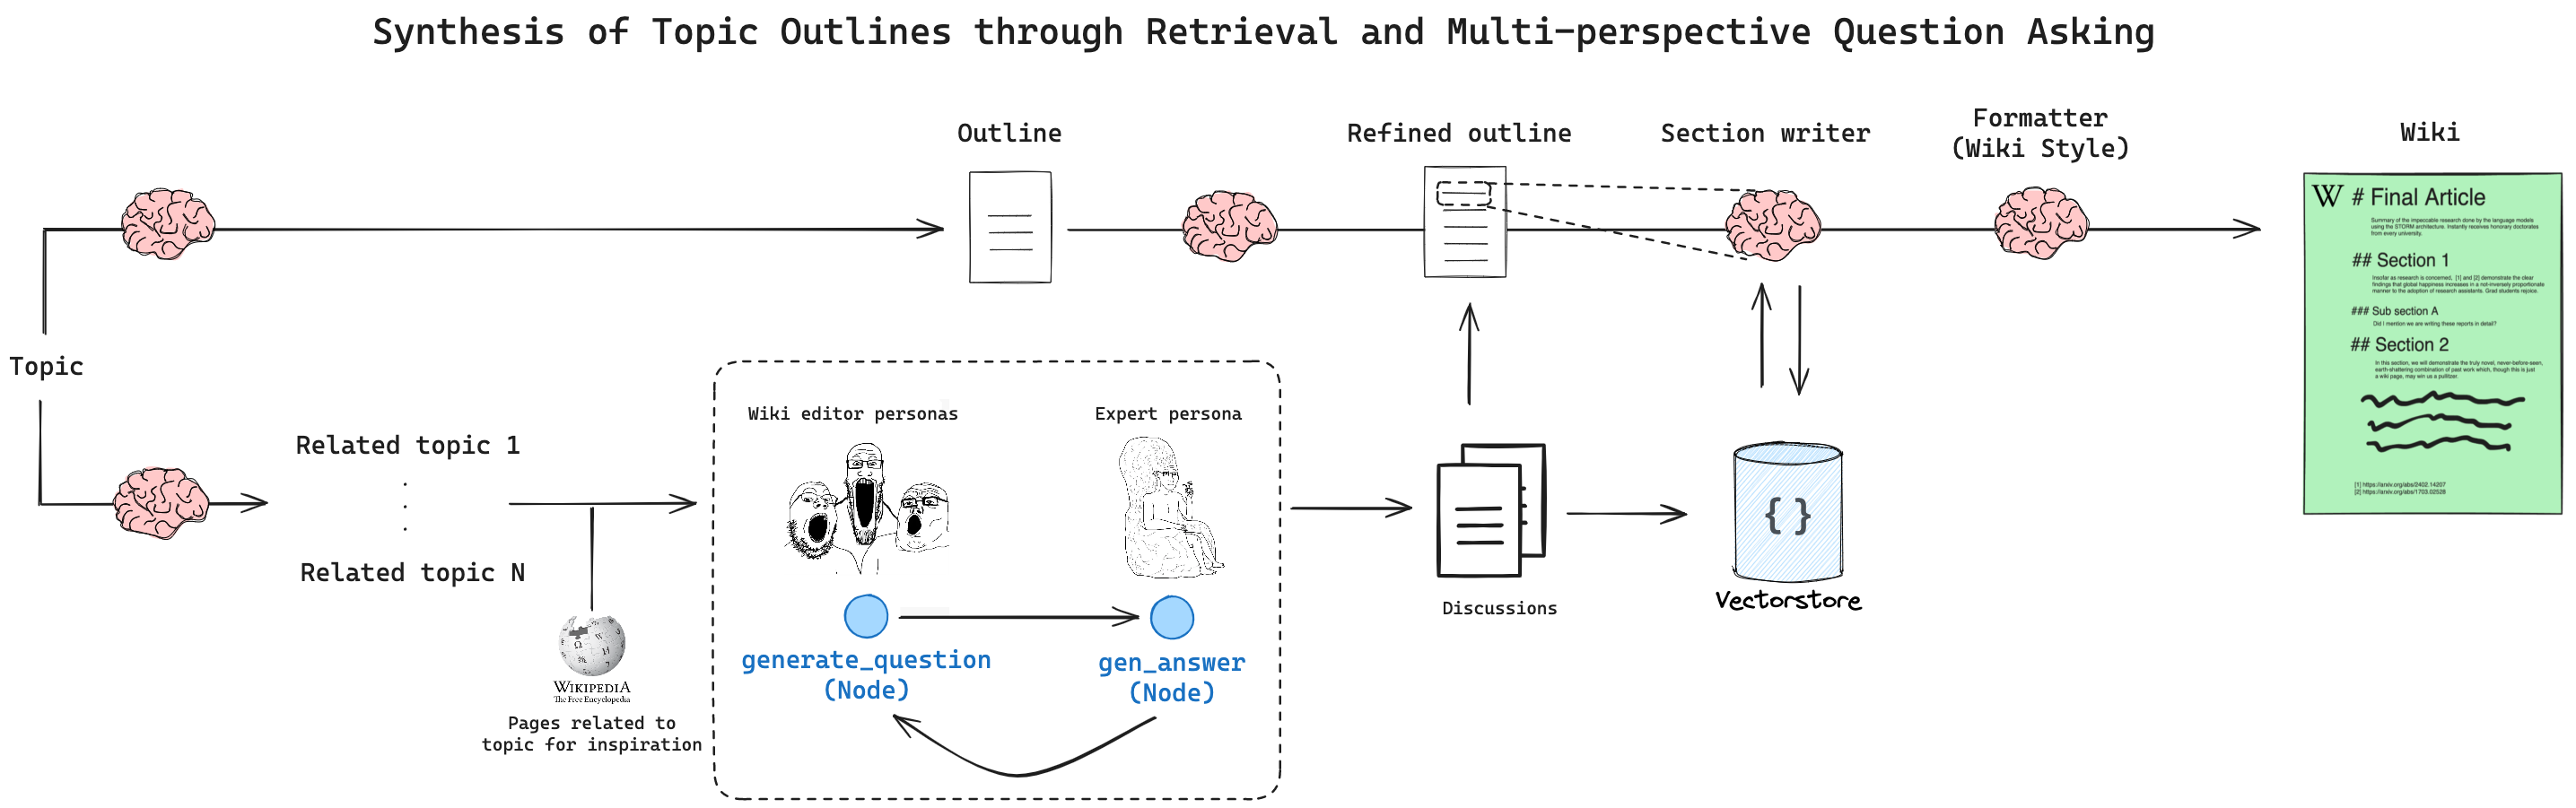

STORM has a few main stages:

1. Generate initial outline + Survey related subjects
2. Identify distinct perspectives
3. "Interview Subject_Matter_Experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article


The expert interviews stage ocurrs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

There are a couple hyperparameters you can set to restrict the (potentially) infinite research breadth:

N: Number of perspectives to survey / use (Steps 2->3)
M: Max number of conversation turns in step (Step 3)


## Prerequisites

In [1]:
! pip install langchain

     ---------------------------------------- 0.0/50.9 kB ? eta -:--:--
     -------- ------------------------------- 10.2/50.9 kB ? eta -:--:--
     ------------------------------ ------- 41.0/50.9 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 50.9/50.9 kB 521.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/974.6 kB ? eta -:--:--
   --- ------------------------------------ 81.9/974.6 kB 4.8 MB/s eta 0:00:01
   ------- -------------------------------- 174.1/974.6 kB 1.8 MB/s eta 0:00:01
   --------- ------------------------------ 225.3/974.6 kB 1.5 MB/s eta 0:00:01
   ------------- -------------------------- 327.7/974.6 kB 2.0 MB/s eta 0:00:01
   ------------------------ --------------- 604.2/974.6 kB 2.5 MB/s eta 0:00:01
   ---------------------------------- ----- 849.9/974.6 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 974.6/974.6 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/315.6 kB ? eta -:

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatible.


In [2]:
! pip install langchain_openai langchain_community

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.2 MB 4.1 MB/s eta 0:00:01
   -- ------------------------------------- 0.2/2.2 MB 1.8 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/2.2 MB 2.0 MB/s eta 0:00:02
   ----- ---------------------------------- 0.3/2.2 MB 2.0 MB/s eta 0:00:01
   ------- -------------------------------- 0.4/2.2 MB 1.8 MB/s eta 0:00:02
   ----------- ---------------------------- 0.6/2.2 MB 2.3 MB/s eta 0:00:01
   ----------------- ---------------------- 0.9/2.2 MB 3.0 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.2 MB 3.5 MB/s eta 0:00:01
   -------------------------------- ------- 1.8/2.2 MB 4.2 MB/s eta 0:00:01
   -------------------------------------- - 2.1/2.2 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 4.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/325.5 kB ? eta -:--:--
   ---------------------

In [3]:
# %pip install -U langchain_community langchain_openai langgraph wikipedia  scikit-learn  langchain_fireworks
# We use one or the other search engine below
# %pip install -U duckduckgo tavily-python

In [4]:
# Uncomment if you want to draw the pretty graph diagrams.
# If you are on MacOS, you will need to run brew install graphviz before installing and update some environment flags
# ! brew install graphviz
# !CFLAGS="-I $(brew --prefix graphviz)/include" LDFLAGS="-L $(brew --prefix graphviz)/lib" pip install -U pygraphviz

In [3]:
import os
import getpass

from dotenv import load_dotenv
load_dotenv()

print('='*30)
os.environ["OPENAI_API_KEY"] = "sk-rODprG14bz0DDDji0789118b88A845E8815929D260627eB5"
for key, value in os.environ.items():
    if 'OPENAI' in key: # openai
        print(f'{key}: {value}')
    if 'DASH' in key: # tongyi
        print(f'{key}: {value}')

OPENAI_API_KEY: sk-rODprG14bz0DDDji0789118b88A845E8815929D260627eB5


In [4]:
### set debug ###
from typing import (
    Any,
    List,
    Optional,
)
import json
from langchain_openai import ChatOpenAI
from langchain_core.language_models.chat_models import generate_from_stream
from langchain_core.messages import BaseMessage
from langchain_core.callbacks import CallbackManagerForLLMRun
from langchain_core.outputs import ChatResult
from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models.chat_models import (
    BaseChatModel,
    agenerate_from_stream,
    generate_from_stream,
)



## Model customization
class CustomChatOpenAI(ChatOpenAI):
    
    # print the raw request 
    def _create_message_dicts(self, *args, **kwargs):
        res = super()._create_message_dicts(*args, **kwargs)
        return res
    
    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        if self.streaming:
            stream_iter = self._stream(
                messages, stop=stop, run_manager=run_manager, **kwargs
            )
            return generate_from_stream(stream_iter)
        message_dicts, params = self._create_message_dicts(messages, stop)
        params = {**params, **kwargs}
        print("【请求体】", '-'*40)
        print('\n'.join([str(i) for i in message_dicts]))
        print(params) 
        print("【请求体 END】", '-'*40)
        response = self.client.create(messages=message_dicts, **params)
        print('【返回RAW】', '-'*40)
        print(response)
        print('【返回RAW END】', '-'*40)
        return self._create_chat_result(response)
    
    # print the raw response(Message)
    def invoke(self, *args, **kwargs):
        res = super().invoke(*args, **kwargs) # AIMessage
        return res
    
   ### TODO: print the parameters
    async def _agenerate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[AsyncCallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        if self.streaming:
            stream_iter = self._astream(
                messages, stop=stop, run_manager=run_manager, **kwargs
            )
            return await agenerate_from_stream(stream_iter)

        message_dicts, params = self._create_message_dicts(messages, stop)
        print("【请求体】", '-'*40)
        print('\n'.join([str(i) for i in message_dicts]))
        print(params) 
        print("【请求体 END】", '-'*40)
        params = {**params, **kwargs}
        response = await self.async_client.create(messages=message_dicts, **params)
        print('【返回RAW】', '-'*40)
        print(response)
        print('【返回RAW END】', '-'*40)
        return self._create_chat_result(response) 


    @staticmethod
    def pretty_print(message):
        import json
        if isinstance(message, dict):
            m_dict = message 
        elif isinstance(message, object):
            m_dict = message.__dict__
        pretty_json = json.dumps(m_dict, indent=4, ensure_ascii=False)
        print(pretty_json)

In [6]:
import asyncio
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")

# Define the model with structured output
model = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0, streaming=True)
structured_llm = model.with_structured_output(Joke)

def stream_joke():
    # Invoke the model and stream the response
    response = structured_llm.stream("Tell me a joke about cats")

    # Initialize an empty Joke object
    joke = Joke(setup="", punchline="")

    # Stream the response
    for part in response:
        if 'setup' in part:
            joke.setup += part['setup']
            print(f"Setup: {joke.setup}")
        if 'punchline' in part:
            joke.punchline += part['punchline']
            print(f"Punchline: {joke.punchline}")

# Run the streaming joke function
stream_joke()

APITimeoutError: Request timed out.

#### Select LLMs

We will have a faster LLM do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [7]:
from langchain_openai import ChatOpenAI
from langchain_fireworks import ChatFireworks

# fast_llm = ChatOpenAI(model="gpt-4")
# fast_llm = ChatOpenAI(model="gpt-4")
# fast_llm = ChatOpenAI(model="gpt-3.5-turbo")
# fast_llm = ChatOpenAI(model='gpt-3.5-turbo')
# fast_llm = CustomChatOpenAI(model='gpt-4o')
fast_llm = CustomChatOpenAI(model='gpt-4') 
# fast_llm = CustomChatOpenAI(model='gpt-3.5-turbo')
# Uncomment for a Fireworks model
long_context_llm = CustomChatOpenAI(model="gpt-4-turbo-preview")

## Generate Initial Outline

For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial
outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

In [8]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你是一名文章题材的撰稿人。为用户提供的主题编写一个类似维基百科页面的大纲。请明确主题并且系统全面的进行撰写。""",
        ),
        ("user", "{topic}"),
    ]
)

class Subsection(BaseModel):
    subsection_title: str = Field(..., title="小节标题")
    description: str = Field(..., title="小节内容")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="章节标题")
    description: str = Field(..., title="章节内容")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="页面各小节的标题和内容。",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="页面标题")
    sections: List[Section] = Field(
        default_factory=list,
        title="页面各章节的标题和内容。",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)


In [9]:
# example_topic = "Impact of million-plus token context window language models on RAG"
# example_topic = "中央企业在新能源产业的布局"
example_topic = "中央企业在新能源产业的布局"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

【请求体】 ----------------------------------------
{'content': '你是一名文章题材的撰稿人。为用户提供的主题编写一个类似维基百科页面的大纲。请明确主题并且系统全面的进行撰写。', 'role': 'system'}
{'content': '中央企业在新能源产业的布局', 'role': 'user'}
{'model': 'gpt-4', 'stream': False, 'n': 1, 'temperature': 0.7, 'tools': [{'type': 'function', 'function': {'name': 'Outline', 'description': '', 'parameters': {'type': 'object', 'properties': {'page_title': {'type': 'string'}, 'sections': {'type': 'array', 'items': {'type': 'object', 'properties': {'section_title': {'type': 'string'}, 'description': {'type': 'string'}, 'subsections': {'type': 'array', 'items': {'type': 'object', 'properties': {'subsection_title': {'type': 'string'}, 'description': {'type': 'string'}}, 'required': ['subsection_title', 'description']}}}, 'required': ['section_title', 'description']}}}, 'required': ['page_title']}}}], 'tool_choice': {'type': 'function', 'function': {'name': 'Outline'}}}
【请求体 END】 ----------------------------------------


APITimeoutError: Request timed out.

## Expand Topics

While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [10]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """我正在为下面提到的主题编写一个类似维基百科页面或者报告。请识别并推荐一些关于密切相关主题的维基百科页面。我正在寻找能够提供与
    该主题常见关联的有趣方面的见解的示例，或帮助我了解类似主题的维基百科页面中包含的典型内容和结构的示例。请列出尽可能多的主题和网址。
    感兴趣的主题：{topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="作为背景研究的相关主题的全面列表。",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [11]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

【请求体】 ----------------------------------------
{'content': '我正在为下面提到的主题编写一个类似维基百科页面或者报告。请识别并推荐一些关于密切相关主题的维基百科页面。我正在寻找能够提供与\n    该主题常见关联的有趣方面的见解的示例，或帮助我了解类似主题的维基百科页面中包含的典型内容和结构的示例。请列出尽可能多的主题和网址。\n    感兴趣的主题：中央企业在新能源产业的布局\n', 'role': 'user'}
{'model': 'gpt-4', 'stream': False, 'n': 1, 'temperature': 0.7}
【请求体 END】 ----------------------------------------


APIConnectionError: Connection error.

## Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as "Subject_Matter_Experts" with distinct
backgrounds and affiliations. These will help distribute the search process to encourage a more well-rounded final report.

In [111]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="编辑的主要所属机构。",
    )
    name: str = Field(
        description="编辑的姓名。",
    )
    role: str = Field(
        description="编辑在该主题背景下的角色。",
    )
    description: str = Field(
        description="编辑的关注点、关切和动机的描述。",
    )

    @property
    def persona(self) -> str:
        return f"姓名: {self.name}\n角色: {self.role}\n所属机构: {self.affiliation}\n描述: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="包含编辑及其角色和所属机构的全面列表。",
        # 添加一个 pydantic 验证/限制，使编辑人数最多为 M
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你需要选择一个多元化（且不同）的维基百科编辑组，他们将共同合作创建一个关于该主题的全面文章。每个编辑都代表与该主题相关的不同观点、角色或所属机构。
               你可以使用其他相关主题的维基百科页面作为灵感。对于每个编辑，添加他们将关注的内容的描述。最多生成6位编辑。相关主题的维基页面大纲供参考：
            {examples}
            
            NOTE: 请使用中文回答。
            """,
        ),
        ("user", "感兴趣的主题：{topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | fast_llm.with_structured_output(Perspectives)

In [11]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda, chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)

def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]

def format_docs(docs):
    res = "\n\n".join(format_doc(doc) for doc in docs)
    print('【WIKI docs】:')
    print(res)
    return res


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [12]:
perspectives = await survey_subjects.ainvoke(example_topic)

【请求体】 ----------------------------------------
{'content': '我正在为下面提到的主题编写一个类似维基百科页面或者报告。请识别并推荐一些关于密切相关主题的维基百科页面。我正在寻找能够提供与\n    该主题常见关联的有趣方面的见解的示例，或帮助我了解类似主题的维基百科页面中包含的典型内容和结构的示例。请列出尽可能多的主题和网址。\n    感兴趣的主题：中央企业在新能源产业的布局\n', 'role': 'user'}
{'model': 'gpt-4o', 'stream': False, 'n': 1, 'temperature': 0.7}
【请求体 END】 ----------------------------------------
【返回RAW】 ----------------------------------------
ChatCompletion(id='chatcmpl-9VsSdppqvMjWSekNh4u7bQpAfafKo', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_BvMOixXH4FIeYMuAuPhAtZyo', function=Function(arguments='{"topics":["中央企业在新能源产业的布局"]}', name='RelatedSubjects'), type='function')]))], created=1717384543, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_5f4bad809a', usage=CompletionUsage(completion_tokens=12, prompt_tokens=168, total_tokens=180))
【返回RAW END】 ---

In [13]:
perspectives.dict()

{'editors': [{'affiliation': '中国社会科学院',
   'name': '李强',
   'role': '能源经济学家',
   'description': '李强关注中央企业在新能源产业的经济效益和市场表现，分析其对中国经济的影响。'},
  {'affiliation': '国家电网',
   'name': '王婷',
   'role': '企业高管',
   'description': '王婷负责国家电网的新能源项目，她将介绍公司在风能、太阳能等领域的具体布局和项目成果。'},
  {'affiliation': '国家发展和改革委员会',
   'name': '张伟',
   'role': '政策专家',
   'description': '张伟专注于国家政策对中央企业新能源布局的影响，解释政府在推动新能源产业方面的政策和措施。'},
  {'affiliation': '清华大学',
   'name': '陈敏',
   'role': '环境科学家',
   'description': '陈敏研究新能源项目对环境的影响，她将评估中央企业在减少碳排放和环境保护方面的贡献。'},
  {'affiliation': '华为技术有限公司',
   'name': '赵磊',
   'role': '技术专家',
   'description': '赵磊专注于新能源技术的发展和创新，介绍中央企业在电池储能、智能电网等前沿技术上的突破。'},
  {'affiliation': '绿色和平组织',
   'name': '刘静',
   'role': '社会活动家',
   'description': '刘静关注新能源项目对社区和社会的影响，探讨中央企业在社会责任和可持续发展方面的表现。'}]}

In [45]:
from langchain.load.dump import dumps

## Expert Dialog

Now the true fun begins, each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generate content to generate a refined outline as well as an updated index of reference documents.


### Interview State

The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [113]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated, Sequence


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

#### Dialog Roles

The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain`), who uses a search engine to answer the questions as accurately as possible.

In [15]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
import redis


### PERSISTENCE
redis_client = redis.StrictRedis(host='localhost', port=6379, db=0)
def serialize_state_to_redis(state, key):
    serialized_state = json.dumps(state)
    redis_client.set(key, serialized_state)

def deserialize_state_from_redis(key):
    serialized_state = redis_client.get(key)
    if serialized_state:
        return json.loads(serialized_state)
    return None
### END PERSISTENCE

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """您是一名经验丰富的维基百科编辑，正在编辑一个特定的页面。除了维基百科编辑的身份，您在研究该主题时还有特定的关注点。现在，您正在与一位专家聊天以获取信息。请提出一些好的问题，以获取更多有用的信息。

当您没有更多问题要问时，请说“非常感谢您的帮助！”来结束对话。
请每次只问一个问题，并且不要重复问之前问过的问题。您的问题应与您要编写的主题相关。
要全面且充满好奇心，从专家那里获得尽可能多的独特见解。

保持您特定的视角：

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message

def swap_roles(state: InterviewState, name: str):
    converted = []
    # print('【Before swapped】')
    # print('\n'.join([str(i.__dict__) for i in state['messages']]))
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    # print('【After swapped】')
    # print('\n'.join([str(i.__dict__) for i in converted]))
    # print('-'*50)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]} 

In [16]:
messages = [
    HumanMessage(f"所以你说你正在写关于{example_topic}的文章？")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content


【请求体】 ----------------------------------------
{'content': '您是一名经验丰富的维基百科编辑，正在编辑一个特定的页面。除了维基百科编辑的身份，您在研究该主题时还有特定的关注点。现在，您正在与一位专家聊天以获取信息。请提出一些好的问题，以获取更多有用的信息。\n\n当您没有更多问题要问时，请说“非常感谢您的帮助！”来结束对话。\n请每次只问一个问题，并且不要重复问之前问过的问题。您的问题应与您要编写的主题相关。\n要全面且充满好奇心，从专家那里获得尽可能多的独特见解。\n\n保持您特定的视角：\n\n姓名: 李强\n角色: 能源经济学家\n所属机构: 中国社会科学院\n描述: 李强关注中央企业在新能源产业的经济效益和市场表现，分析其对中国经济的影响。\n', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'role': 'user'}
{'model': 'gpt-4o', 'stream': False, 'n': 1, 'temperature': 0.7}
【请求体 END】 ----------------------------------------
【返回RAW】 ----------------------------------------
ChatCompletion(id='chatcmpl-9VsSt7EHv2a5YgX4woT5LPN5Q8uvy', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='是的，李教授，我正在写一篇关于中央企业在新能源产业的布局的文章。能否请您谈谈近年来中央企业在新能源领域投资的主要方向和重点项目？', role='assistant', function_call=None, tool_calls=None))], created=1717384559, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_5f4bad809a', u

'是的，李教授，我正在写一篇关于中央企业在新能源产业的布局的文章。能否请您谈谈近年来中央企业在新能源领域投资的主要方向和重点项目？'

#### Answer questions

The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [17]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="搜索引擎查询的全面列表，用于回答用户的问题。",
    )

gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "您是一位乐于助人的研究助理。查询搜索引擎以回答用户的问题。",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model="gpt-4o"
).with_structured_output(Queries, include_raw=True)


In [18]:
# query重写
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['近年来中央企业在新能源领域投资的主要方向', '中央企业新能源领域重点项目']

In [19]:
queries

{'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UXj9VvImfQmkYzkripRxE8KE', 'function': {'arguments': '{"queries":["近年来中央企业在新能源领域投资的主要方向","中央企业新能源领域重点项目"]}', 'name': 'Queries'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 123, 'total_tokens': 145}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, id='run-96896a60-fe0a-4070-988f-ea10cd1ed585-0', tool_calls=[{'name': 'Queries', 'args': {'queries': ['近年来中央企业在新能源领域投资的主要方向', '中央企业新能源领域重点项目']}, 'id': 'call_UXj9VvImfQmkYzkripRxE8KE'}]),
 'parsed': Queries(queries=['近年来中央企业在新能源领域投资的主要方向', '中央企业新能源领域重点项目']),
 'parsing_error': None}

In [20]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="用中文回答用户问题的全面答案并附上引用。",
    )
    cited_urls: List[str] = Field(
        description="答案中引用的URL列表。",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\n引用:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。

使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。
每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

'''
# Tavily is typically a better search engine, but your free queries are limited
search_engine = TavilySearchResults(max_results=4)

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = tavily_search.invoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]
'''

# DDG 
search_engine = DuckDuckGoSearchAPIWrapper()

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    print('[Searching query]: %s' % query)
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query, max_results=5)
    return [{"content": r["body"], "url": r["href"]} for r in results]


In [22]:
from langchain_core.runnables import RunnableConfig
import json
from tenacity import retry, stop_after_attempt, wait_exponential
import traceback

def print_retrying(retry_state):
    print("Retrying...")
    if retry_state.outcome.failed:
        traceback.print_exception(type(retry_state.outcome.exception()), 
                                  retry_state.outcome.exception(),
                                  retry_state.outcome.exception().__traceback__)

@retry(stop=stop_after_attempt(5), 
       wait=wait_exponential(multiplier=1, min=2, max=5), 
       before_sleep=print_retrying)
async def retryable_gen_answer_chain(swapped_state, name=None, all_query_results=None):
    generated =  await gen_answer_chain.ainvoke(swapped_state)
    # generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return formatted_message, cited_references
 
 
@retry(stop=stop_after_attempt(5), 
       wait=wait_exponential(multiplier=1, min=2, max=5), 
       before_sleep=print_retrying)
async def retryable_gen_queries_chain(swapped_state):
    queries = await gen_queries_chain.ainvoke(swapped_state)
    if queries["parsed"] is None:
        raise Exception('Query generated is None, Retrying')
    return queries 
 
async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 7000,
    redis_key: str = "interview_state" ### TODO: persistence
):
    # Check if there is a serialized state in Redis
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await retryable_gen_queries_chain(swapped_state)
    print('【2】Generated query expansions %s' % queries["parsed"].queries)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # print("【2】Generated query results", all_query_results)
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    # print('【3】 dumped result %s, \n -- \n length %s' % (dumped, len(dumped)))
    
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].additional_kwargs["tool_calls"][0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    
    # print("【4】Got tool_call %s" % queries["raw"].additional_kwargs["tool_calls"])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    print('【3】Swapped state: %s' % swapped_state)
    formatted_message, cited_references = await retryable_gen_answer_chain(swapped_state, 
                                                 name=name, 
                                                 all_query_results=all_query_results) 
    

    # Clear the Redis state after successful completion
    # redis_client.delete(redis_key)
    return {"messages": [formatted_message], "references": cited_references}




In [23]:
question["messages"][0].content

'是的，李教授，我正在写一篇关于中央企业在新能源产业的布局的文章。能否请您谈谈近年来中央企业在新能源领域投资的主要方向和重点项目？'

In [24]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

【2】Generated query expansions ['近年来中央企业在新能源领域投资的主要方向', '中央企业新能源重点项目']
[Searching query]: 近年来中央企业在新能源领域投资的主要方向
[Searching query]: 中央企业新能源重点项目
【3】Swapped state: {'messages': [HumanMessage(content='是的，李教授，我正在写一篇关于中央企业在新能源产业的布局的文章。能否请您谈谈近年来中央企业在新能源领域投资的主要方向和重点项目？'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Fe5bXcU2tkGVf7cqKH7vgGDc', 'function': {'arguments': '{"queries":["近年来中央企业在新能源领域投资的主要方向","中央企业新能源重点项目"]}', 'name': 'Queries'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 123, 'total_tokens': 144}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, id='run-3e88baf3-8937-4fc9-87ae-86f68216b277-0', tool_calls=[{'name': 'Queries', 'args': {'queries': ['近年来中央企业在新能源领域投资的主要方向', '中央企业新能源重点项目']}, 'id': 'call_Fe5bXcU2tkGVf7cqKH7vgGDc'}]), ToolMessage(content='{"https://finance.sina.com.cn/stock/stockzmt/2024-04-07/doc-inaqzcvq6205469.shtml": "\\u503c\\u5f97\\

'近年来，中央企业在新能源领域的投资方向主要集中在以下几个方面：\n\n1. **风电和光伏**：这是当前中央企业在新能源领域的重点投资方向。许多中央企业，如国家能源集团、中国华电集团等，纷纷在全国各地建设大规模的风电和光伏发电项目。例如，国家能源集团在2024年启动了多个大型风电和光伏项目，总投资高达1260亿元人民币。[1]\n\n2. **新能源电动车**：中央企业在新能源汽车领域也有显著布局。中国兵器装备集团旗下的长安汽车和东风汽车集团都在大力推进电动化转型，推出高端电动汽车品牌，并加大对新能源汽车研发和生产的投入。[2]\n\n3. **氢能和储能**：氢能和储能被视为未来能源的重要组成部分，中央企业在这两个领域也进行了大量投资。例如，国家电投集团和华能集团都在开发氢能项目，并探索储能技术的应用。[3]\n\n4. **清洁煤电**：尽管煤炭仍是中国能源结构中的重要组成部分，但中央企业正在推动煤炭的清洁高效利用，开发先进的燃煤技术，以减少污染和提高能源利用效率。[4]\n\n主要的重点项目包括：\n\n- **国家能源集团的风电和光伏项目**：2024年，国家能源集团启动了37个重点电力项目，包括大型风电光伏基地和海上光伏项目，总投资1260亿元人民币。[1]\n\n- **长安汽车的“香格里拉”计划**：这是中国兵器装备集团旗下长安汽车实施的一项全面电动化转型计划，旨在推动电动车的发展。[2]\n\n- **中国电建的塔吉克斯坦风电项目**：这是中国电力建设集团在“一带一路”倡议下的重要项目，展示了中央企业在国际新能源市场的布局。[5]\n\n总的来说，中央企业在新能源领域的投资呈现出多元化、高技术含量和大规模的特点，涵盖了风电、光伏、新能源汽车、氢能、储能和清洁煤电等多个方面，显示出其在推动能源转型和实现“双碳”目标中的关键作用。\n\n引用:\n\n[1]: https://www.chnenergy.com.cn/gjnyjtww/chnjtyw/202310/8bc0267aa87244ae8dc113bd311abd80.shtml\n[2]: https://www.thepaper.cn/newsDetail_forward_27065135\n[3]: https://finance.sina.com.cn/stock/stockzmt/

In [25]:
example_answer

{'messages': [AIMessage(content='近年来，中央企业在新能源领域的投资方向主要集中在以下几个方面：\n\n1. **风电和光伏**：这是当前中央企业在新能源领域的重点投资方向。许多中央企业，如国家能源集团、中国华电集团等，纷纷在全国各地建设大规模的风电和光伏发电项目。例如，国家能源集团在2024年启动了多个大型风电和光伏项目，总投资高达1260亿元人民币。[1]\n\n2. **新能源电动车**：中央企业在新能源汽车领域也有显著布局。中国兵器装备集团旗下的长安汽车和东风汽车集团都在大力推进电动化转型，推出高端电动汽车品牌，并加大对新能源汽车研发和生产的投入。[2]\n\n3. **氢能和储能**：氢能和储能被视为未来能源的重要组成部分，中央企业在这两个领域也进行了大量投资。例如，国家电投集团和华能集团都在开发氢能项目，并探索储能技术的应用。[3]\n\n4. **清洁煤电**：尽管煤炭仍是中国能源结构中的重要组成部分，但中央企业正在推动煤炭的清洁高效利用，开发先进的燃煤技术，以减少污染和提高能源利用效率。[4]\n\n主要的重点项目包括：\n\n- **国家能源集团的风电和光伏项目**：2024年，国家能源集团启动了37个重点电力项目，包括大型风电光伏基地和海上光伏项目，总投资1260亿元人民币。[1]\n\n- **长安汽车的“香格里拉”计划**：这是中国兵器装备集团旗下长安汽车实施的一项全面电动化转型计划，旨在推动电动车的发展。[2]\n\n- **中国电建的塔吉克斯坦风电项目**：这是中国电力建设集团在“一带一路”倡议下的重要项目，展示了中央企业在国际新能源市场的布局。[5]\n\n总的来说，中央企业在新能源领域的投资呈现出多元化、高技术含量和大规模的特点，涵盖了风电、光伏、新能源汽车、氢能、储能和清洁煤电等多个方面，显示出其在推动能源转型和实现“双碳”目标中的关键作用。\n\n引用:\n\n[1]: https://www.chnenergy.com.cn/gjnyjtww/chnjtyw/202310/8bc0267aa87244ae8dc113bd311abd80.shtml\n[2]: https://www.thepaper.cn/newsDetail_forward_27065135\n[3]: https://fin

In [26]:
def wrap_text(text, chars_per_line=50):
    # Create a list to hold the wrapped lines
    wrapped_lines = []
    
    # Iterate through the text in chunks of chars_per_line
    for i in range(0, len(text), chars_per_line):
        # Slice the text to get each line and add it to wrapped_lines
        wrapped_lines.append(text[i:i + chars_per_line])
    
    # Join the wrapped lines with newline characters
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

In [27]:
example_answer

{'messages': [AIMessage(content='近年来，中央企业在新能源领域的投资方向主要集中在以下几个方面：\n\n1. **风电和光伏**：这是当前中央企业在新能源领域的重点投资方向。许多中央企业，如国家能源集团、中国华电集团等，纷纷在全国各地建设大规模的风电和光伏发电项目。例如，国家能源集团在2024年启动了多个大型风电和光伏项目，总投资高达1260亿元人民币。[1]\n\n2. **新能源电动车**：中央企业在新能源汽车领域也有显著布局。中国兵器装备集团旗下的长安汽车和东风汽车集团都在大力推进电动化转型，推出高端电动汽车品牌，并加大对新能源汽车研发和生产的投入。[2]\n\n3. **氢能和储能**：氢能和储能被视为未来能源的重要组成部分，中央企业在这两个领域也进行了大量投资。例如，国家电投集团和华能集团都在开发氢能项目，并探索储能技术的应用。[3]\n\n4. **清洁煤电**：尽管煤炭仍是中国能源结构中的重要组成部分，但中央企业正在推动煤炭的清洁高效利用，开发先进的燃煤技术，以减少污染和提高能源利用效率。[4]\n\n主要的重点项目包括：\n\n- **国家能源集团的风电和光伏项目**：2024年，国家能源集团启动了37个重点电力项目，包括大型风电光伏基地和海上光伏项目，总投资1260亿元人民币。[1]\n\n- **长安汽车的“香格里拉”计划**：这是中国兵器装备集团旗下长安汽车实施的一项全面电动化转型计划，旨在推动电动车的发展。[2]\n\n- **中国电建的塔吉克斯坦风电项目**：这是中国电力建设集团在“一带一路”倡议下的重要项目，展示了中央企业在国际新能源市场的布局。[5]\n\n总的来说，中央企业在新能源领域的投资呈现出多元化、高技术含量和大规模的特点，涵盖了风电、光伏、新能源汽车、氢能、储能和清洁煤电等多个方面，显示出其在推动能源转型和实现“双碳”目标中的关键作用。\n\n引用:\n\n[1]: https://www.chnenergy.com.cn/gjnyjtww/chnjtyw/202310/8bc0267aa87244ae8dc113bd311abd80.shtml\n[2]: https://www.thepaper.cn/newsDetail_forward_27065135\n[3]: https://fin

In [28]:
### Multi agents###

#### Construct the Interview Graph


Now that we've defined the editor and domain expert, we can compose them in a graph.

In [29]:
names = [
    "James",
    "Olivia",
    "William",
    "Emma",
    "Benjamin",
    "Sophia",
    "Lucas",
    "Mia",
    "Henry",
]

for e in perspectives.editors:
    e.name = names.pop()

In [30]:
max_num_turns = 5


def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END 
    ### newly added
    if last_question.content.endswith("非常感谢您的帮助!"):
        return END
    
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question)
builder.add_node("answer_question", gen_answer)
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.set_entry_point("ask_question")
interview_graph = builder.compile().with_config(run_name="Conduct Interviews")

<img src="agent.png" alt="Agent Image" width="300" height="400">

In [31]:
question['messages']

[AIMessage(content='是的，李教授，我正在写一篇关于中央企业在新能源产业的布局的文章。能否请您谈谈近年来中央企业在新能源领域投资的主要方向和重点项目？', response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 218, 'total_tokens': 259}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='李强', id='run-9ca148f6-17d2-4705-8f3e-a066c9061cc8-0')]

In [35]:
all_interviews = []
async def run_interviews_for_all_editors(editors, example_topic):
    for i, editor in enumerate(editors):
        print('【Editor】: %s -- %s' % (i, editor.name))
        initial_state = {
            "editor": editor,
            "messages": [
                # HumanMessage(content=question["messages"][0].content),
                AIMessage(
                    content=f"所以你说你正在写关于{example_topic}的文章？",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        
        states = {'messages': [], 'references': {}, 'editor': editor}
        final_step = None
        async for step in interview_graph.astream(initial_state):
            name = next(iter(step))
            print(name) ### node name
            print('--', str(step[name]['messages'])[:300])
            states['messages'].extend(step[name]["messages"])
            if name == 'answer_question': #TODO
                states['references'].update(step[name]['references'])
            if END in step:
                final_step = step
                break
        
        all_interviews.append(states)
        
    return all_interviews


editors = perspectives.editors  # Assuming this is defined somewhere

In [36]:
all_interview_results = await run_interviews_for_all_editors(editors, example_topic)

【Editor】: 0 -- Henry
【请求体】 ----------------------------------------
{'content': '您是一名经验丰富的维基百科编辑，正在编辑一个特定的页面。除了维基百科编辑的身份，您在研究该主题时还有特定的关注点。现在，您正在与一位专家聊天以获取信息。请提出一些好的问题，以获取更多有用的信息。\n\n当您没有更多问题要问时，请说“非常感谢您的帮助！”来结束对话。\n请每次只问一个问题，并且不要重复问之前问过的问题。您的问题应与您要编写的主题相关。\n要全面且充满好奇心，从专家那里获得尽可能多的独特见解。\n\n保持您特定的视角：\n\n姓名: Henry\n角色: 能源经济学家\n所属机构: 中国社会科学院\n描述: 李强关注中央企业在新能源产业的经济效益和市场表现，分析其对中国经济的影响。\n', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'user'}
{'model': 'gpt-4o', 'stream': False, 'n': 1, 'temperature': 0.7}
【请求体 END】 ----------------------------------------
【返回RAW】 ----------------------------------------
ChatCompletion(id='chatcmpl-H9EVIVRF9CO0to7NS0O6ybxk4O1Sh', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', role='assistant', function_call=None, tool_calls=None))], created=1717388175, model='gpt-4o', object='chat.completion

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['中央企业 新能源产业 投资 领域', '中央企业 新能源 主要投资领域', '中央企业 新能源产业 投资分布']
[Searching query]: 中央企业 新能源产业 投资 领域
[Searching query]: 中央企业 新能源 主要投资领域
[Searching query]: 中央企业 新能源产业 投资分布
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 309, 'total_tokens': 372}, 'model_name': 'gpt-4o', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='Henry', id='run-115397a0-f0b6-4669-a087-29ff038a3898-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_A9PxZaIxLB4nWL7geqEdbkTu', 'function': {'arguments': '{"queries":["中央企业 新能源产业 投资 领域","中央企业 新能源 主要投资领域","中央企业 新能源产业 投资分布"]}', 'name': 'Queries'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tok

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', 'name': 'Henry', 'role': 'user'}
{'content': None, 'role': 'assistant', 'tool_calls': [{'type': 'function', 'id': 'call_A9PxZaIxLB4nWL7geqEdbkTu', 'function': {'name': 'Queries', 'arguments': '{"queries": ["\\u4e2d\\u592e\\u4f01\\u4e1a \\u65b0\\u80fd\\u6e90\\u4ea7\\u4e1a \\u6295\\u8d44 \\u9886\\u57df", "\\u4e2d\\u592e\\u4f01\\u4e1a \\u65b0\\u80fd\\u6e90 \\u4e3b\\u8981\\u6295\\u8d44\\u9886\\u57df", "\\u4e2d\\u592e\\u4f01\\u4e1a \\u65b0\\u80fd\\u6e90\\u4ea7\\u4e1a \\u6295\\u8d44\\u5206\\u5e03"]}'}}]}
{'content': '{"https://new.qq.com/rain/a/20240518A060FH00": "\\u672c\\u62a5\\uff08chinatimes.net.c

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', 'name': 'Henry', 'role': 'user'}
{'content': '中央企业在新能源产业的投资主要集中在以下几个领域：\n\n1. **风力发电**：中央企业大规模投资于风力发电技术和服务，建立了多个二级、三级子公司来覆盖这一领域。\n\n2. **太阳能发电**：太阳能发电技术和服务也是中央企业的重要投资领域。\n\n3. **储能技术**：为了支持新能源的稳定供应，中央企业在储能技术方面进行了大量投资。\n\n4. **新能源汽车**：包括电动汽车技术的研发和生产。\n\n5. **氢能**：氢能技术也是投资的一个重要方向。\n\n此外，中央企业还在生物质能、水力发电等其他清洁能源领域进行了布局。\n\n参考资料：[腾讯新闻](https://new.qq.com/rain/a/20240518A060FH00)、[新浪财经](https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml)\n\n引用:\n\n[1]: https://new.qq.com/rain/a/20240518A060FH00\n[2]: https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml', 'name': 'Subject

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['中央企业在新能源产业投资面临的主要挑战和风险', '中央企业如何应对新能源产业投资中的挑战和风险', '中国华能集团新能源投资风险管理', '国家电投集团新能源投资挑战应对措施', '中国石化氢能项目面临的风险及应对策略']
[Searching query]: 中央企业在新能源产业投资面临的主要挑战和风险
[Searching query]: 中央企业如何应对新能源产业投资中的挑战和风险
[Searching query]: 中国华能集团新能源投资风险管理
[Searching query]: 国家电投集团新能源投资挑战应对措施
[Searching query]: 中国石化氢能项目面临的风险及应对策略
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 309, 'total_tokens': 372}, 'model_name': 'gpt-4o', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='Henry', id='run-115397a0-f0b6-4669-a087-29ff038a3898-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='中央企业在新能源产业的投资主要集中在以下几个领域：\n\n1. **风力发电**：中央企业大规模投资于风力发电技术和服务，建立了多个二级、三级子公司来覆盖这一领域。\n\n2. **太阳能发电**：太阳能发电技术和服务也是中央企业的重要投资领域。\n\n3. **储能技术**：为了支持新能

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


Retrying...


Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['国家电网 风能项目', '国家电网 风能布局', '国家电网 风力发电 主要项目']
[Searching query]: 国家电网 风能项目
[Searching query]: 国家电网 风能布局
[Searching query]: 国家电网 风力发电 主要项目
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，没错。那让我们从这里开始：\n\n王婷，您能详细介绍一下国家电网目前在风能领域的主要项目和布局吗？', response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 225, 'total_tokens': 261}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Mia', id='run-2677de52-2b10-4243-a112-e312b9a9a7c5-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_B8Stopa7HUqMtKS8gg2slKZK', 'function': {'arguments': '{"queries":["国家电网 风能项目","国家电网 风能布局","国家电网 风力发电 主要项目"]}', 'name': 'Queries'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 147, 'total_tokens': 176}, 'model

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['国家电网 太阳能 主要项目 布局']
[Searching query]: 国家电网 太阳能 主要项目 布局
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，没错。那让我们从这里开始：\n\n王婷，您能详细介绍一下国家电网目前在风能领域的主要项目和布局吗？', response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 225, 'total_tokens': 261}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Mia', id='run-2677de52-2b10-4243-a112-e312b9a9a7c5-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='国家电网在风能领域的主要布局和项目包括以下几个方面：\n\n1. **乌兰察布风电基地**：这是目前全球陆上单体最大的风电项目。该项目一期600万千瓦示范项目首批120万千瓦已经并网发电，总投资60亿元，年发电量可达36亿千瓦时，预计每年可减少标准煤消耗120万吨，减少二氧化碳排放306万吨。[1]\n\n2. **分散式风电项目**：国家电网南网能源公司首个分散式风电项目——茂名信宜贵子风电场项目正式核准通过，这标志着南网能源公司分散式风电业务开发实现重要突破。[2]\n\n3. **技术创新和项目建设**：国家电投将继续深入开展技术创新和产业创新，加大推进项目建设力度，助推黑龙江省打造世界级多元绿色能源化工产业高地。[3]\n\n国家电网通过大规模投资和技术创新，积极布局风能产业，为推动新能源的发展作出了重要贡献。\n\n引用:\n\n[1]: https://cpnn.c

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，没错。那让我们从这里开始：\n\n王婷，您能详细介绍一下国家电网目前在风能领域的主要项目和布局吗？', 'name': 'Mia', 'role': 'user'}
{'content': '国家电网在风能领域的主要布局和项目包括以下几个方面：\n\n1. **乌兰察布风电基地**：这是目前全球陆上单体最大的风电项目。该项目一期600万千瓦示范项目首批120万千瓦已经并网发电，总投资60亿元，年发电量可达36亿千瓦时，预计每年可减少标准煤消耗120万吨，减少二氧化碳排放306万吨。[1]\n\n2. **分散式风电项目**：国家电网南网能源公司首个分散式风电项目——茂名信宜贵子风电场项目正式核准通过，这标志着南网能源公司分散式风电业务开发实现重要突破。[2]\n\n3. **技术创新和项目建设**：国家电投将继续深入开展技术创新和产业创新，加大推进项目建设力度，助推黑龙江省打造世界级多元绿色能源化工产业高地。[3]\n\n国家电网通过大规模投资和技术创新，积极布局风能产业，为推动新能源的发展作出了重要贡献。\n\n引用:\n\n[1]: https://cpnn.com.cn/news/hy/202401/t20240102_1665756.html\n[2]: http://www.chinapower.com.cn/flfd/xmjz/20240417/242687.html\n[3]: https://wind.in-en.com/html/wind-2439848.shtml', 'name

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，没错。那让我们从这里开始：\n\n王婷，您能详细介绍一下国家电网目前在风能领域的主要项目和布局吗？', 'name': 'Mia', 'role': 'user'}
{'content': '国家电网在风能领域的主要布局和项目包括以下几个方面：\n\n1. **乌兰察布风电基地**：这是目前全球陆上单体最大的风电项目。该项目一期600万千瓦示范项目首批120万千瓦已经并网发电，总投资60亿元，年发电量可达36亿千瓦时，预计每年可减少标准煤消耗120万吨，减少二氧化碳排放306万吨。[1]\n\n2. **分散式风电项目**：国家电网南网能源公司首个分散式风电项目——茂名信宜贵子风电场项目正式核准通过，这标志着南网能源公司分散式风电业务开发实现重要突破。[2]\n\n3. **技术创新和项目建设**：国家电投将继续深入开展技术创新和产业创新，加大推进项目建设力度，助推黑龙江省打造世界级多元绿色能源化工产业高地。[3]\n\n国家电网通过大规模投资和技术创新，积极布局风能产业，为推动新能源的发展作出了重要贡献。\n\n引用:\n\n[1]: https://cpnn.com.cn/news/hy/202401/t20240102_1665756.html\n[2]: http://www.chinapower.com.cn/flfd/xmjz/20240417/242687.html\n[3]: https://wind.in-en.com/html/wind-2439848.shtml', 'name

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['国家电网 新能源项目 成功案例', '国家电网 新能源项目 当地经济环境影响']
[Searching query]: 国家电网 新能源项目 成功案例
[Searching query]: 国家电网 新能源项目 当地经济环境影响
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，没错。那让我们从这里开始：\n\n王婷，您能详细介绍一下国家电网目前在风能领域的主要项目和布局吗？', response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 225, 'total_tokens': 261}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Mia', id='run-2677de52-2b10-4243-a112-e312b9a9a7c5-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='国家电网在风能领域的主要布局和项目包括以下几个方面：\n\n1. **乌兰察布风电基地**：这是目前全球陆上单体最大的风电项目。该项目一期600万千瓦示范项目首批120万千瓦已经并网发电，总投资60亿元，年发电量可达36亿千瓦时，预计每年可减少标准煤消耗120万吨，减少二氧化碳排放306万吨。[1]\n\n2. **分散式风电项目**：国家电网南网能源公司首个分散式风电项目——茂名信宜贵子风电场项目正式核准通过，这标志着南网能源公司分散式风电业务开发实现重要突破。[2]\n\n3. **技术创新和项目建设**：国家电投将继续深入开展技术创新和产业创新，加大推进项目建设力度，助推黑龙江省打造世界级多元绿色能源化工产业高地。[3]\n\n国家电网通过大规模投资和技

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，没错。那让我们从这里开始：\n\n王婷，您能详细介绍一下国家电网目前在风能领域的主要项目和布局吗？', 'name': 'Mia', 'role': 'user'}
{'content': '国家电网在风能领域的主要布局和项目包括以下几个方面：\n\n1. **乌兰察布风电基地**：这是目前全球陆上单体最大的风电项目。该项目一期600万千瓦示范项目首批120万千瓦已经并网发电，总投资60亿元，年发电量可达36亿千瓦时，预计每年可减少标准煤消耗120万吨，减少二氧化碳排放306万吨。[1]\n\n2. **分散式风电项目**：国家电网南网能源公司首个分散式风电项目——茂名信宜贵子风电场项目正式核准通过，这标志着南网能源公司分散式风电业务开发实现重要突破。[2]\n\n3. **技术创新和项目建设**：国家电投将继续深入开展技术创新和产业创新，加大推进项目建设力度，助推黑龙江省打造世界级多元绿色能源化工产业高地。[3]\n\n国家电网通过大规模投资和技术创新，积极布局风能产业，为推动新能源的发展作出了重要贡献。\n\n引用:\n\n[1]: https://cpnn.com.cn/news/hy/202401/t20240102_1665756.html\n[2]: http://www.chinapower.com.cn/flfd/xmjz/20240417/242687.html\n[3]: https://wind.in-en.com/html/wind-2439848.shtml', 'name

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['中国政府推动新能源产业的主要政策和措施', '中国新能源政策', '中国政府新能源产业支持']
[Searching query]: 中国政府推动新能源产业的主要政策和措施
[Searching query]: 中国新能源政策
[Searching query]: 中国政府新能源产业支持
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，没错。为了更好地理解这个主题，我想请教一些问题。\n\n首先，您能否简要概述一下中国政府在推动新能源产业方面的主要政策和措施？', response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 227, 'total_tokens': 270}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Lucas', id='run-c8336f37-535b-4606-b3b0-f22f0ed32b9a-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BvMOixXH4FIeYMuAuPhAtZyo', 'function': {'arguments': '{"queries":["中国政府推动新能源产业的主要政策和措施","中国新能源政策","中国政府新能源产业支持"]}', 'name': 'Queries'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 15

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['中国政府在推动新能源产业方面的政策对中央企业的影响', '中央企业在新能源领域的布局情况', '中央企业在新能源产业中的角色和作用', '中国中央企业新能源项目案例']
[Searching query]: 中国政府在推动新能源产业方面的政策对中央企业的影响
[Searching query]: 中央企业在新能源领域的布局情况
[Searching query]: 中央企业在新能源产业中的角色和作用
[Searching query]: 中国中央企业新能源项目案例
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，没错。为了更好地理解这个主题，我想请教一些问题。\n\n首先，您能否简要概述一下中国政府在推动新能源产业方面的主要政策和措施？', response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 227, 'total_tokens': 270}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Lucas', id='run-c8336f37-535b-4606-b3b0-f22f0ed32b9a-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='中国政府在推动新能源产业方面采取了一系列政策和措施，以促进新能源的高质量发展。这些政策和措施主要包括以下几个方面：\n\n1. **财政激励**：政府通过减免新能源车辆购置税、提供财政补贴等方式，降低消费者购买新能源车辆的成本。例如，财政部和税务总局发布公告，将新能源车购置税减免政策延长至2027年12月31日。[^1^\n\n2. **基建设施**：大力推进充电基础设施建设，加快充电桩和换电

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，没错。为了更好地理解这个主题，我想请教一些问题。\n\n首先，您能否简要概述一下中国政府在推动新能源产业方面的主要政策和措施？', 'name': 'Lucas', 'role': 'user'}
{'content': '中国政府在推动新能源产业方面采取了一系列政策和措施，以促进新能源的高质量发展。这些政策和措施主要包括以下几个方面：\n\n1. **财政激励**：政府通过减免新能源车辆购置税、提供财政补贴等方式，降低消费者购买新能源车辆的成本。例如，财政部和税务总局发布公告，将新能源车购置税减免政策延长至2027年12月31日。[^1^\n\n2. **基建设施**：大力推进充电基础设施建设，加快充电桩和换电站的布局，以解决新能源车辆的充电问题。国家还推动了智慧能源系统的建设，以提高能源利用效率。[^2^\n\n3. **市场化推广**：推动新能源在各个市场的全面应用，鼓励企业和消费者采用新能源技术。国家出台了一系列政策，支持新能源车辆在公共交通、物流运输等领域的应用。[^3^\n\n4. **研发和创新**：中国政府高度重视新能源技术的研发和创新，支持企业和科研机构在电池、电机、控制系统等关键技术领域进行研发。[^4^\n\n5. **国际合作**：加强与国际组织和其他国家在新能源领域的合作，参与全球能源治理，推动新能源技术和标准的国际化。[^5^\n\n这些政策和措施共同推动了中国新能源产业的快速发展，使中国在全球新能源市场中占据了重要地位。\n\n引用:\n\n[1]: https://w

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，没错。为了更好地理解这个主题，我想请教一些问题。\n\n首先，您能否简要概述一下中国政府在推动新能源产业方面的主要政策和措施？', 'name': 'Lucas', 'role': 'user'}
{'content': '中国政府在推动新能源产业方面采取了一系列政策和措施，以促进新能源的高质量发展。这些政策和措施主要包括以下几个方面：\n\n1. **财政激励**：政府通过减免新能源车辆购置税、提供财政补贴等方式，降低消费者购买新能源车辆的成本。例如，财政部和税务总局发布公告，将新能源车购置税减免政策延长至2027年12月31日。[^1^\n\n2. **基建设施**：大力推进充电基础设施建设，加快充电桩和换电站的布局，以解决新能源车辆的充电问题。国家还推动了智慧能源系统的建设，以提高能源利用效率。[^2^\n\n3. **市场化推广**：推动新能源在各个市场的全面应用，鼓励企业和消费者采用新能源技术。国家出台了一系列政策，支持新能源车辆在公共交通、物流运输等领域的应用。[^3^\n\n4. **研发和创新**：中国政府高度重视新能源技术的研发和创新，支持企业和科研机构在电池、电机、控制系统等关键技术领域进行研发。[^4^\n\n5. **国际合作**：加强与国际组织和其他国家在新能源领域的合作，参与全球能源治理，推动新能源技术和标准的国际化。[^5^\n\n这些政策和措施共同推动了中国新能源产业的快速发展，使中国在全球新能源市场中占据了重要地位。\n\n引用:\n\n[1]: https://w

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['中央企业 新能源 成功案例', '中央企业 响应政府政策 新能源 典型案例', '中国 电力企业 新能源 布局 成功案例', '中国 石化 新能源 成功案例']
[Searching query]: 中央企业 新能源 成功案例
[Searching query]: 中央企业 响应政府政策 新能源 典型案例
[Searching query]: 中国 电力企业 新能源 布局 成功案例
[Searching query]: 中国 石化 新能源 成功案例
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，没错。为了更好地理解这个主题，我想请教一些问题。\n\n首先，您能否简要概述一下中国政府在推动新能源产业方面的主要政策和措施？', response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 227, 'total_tokens': 270}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Lucas', id='run-c8336f37-535b-4606-b3b0-f22f0ed32b9a-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='中国政府在推动新能源产业方面采取了一系列政策和措施，以促进新能源的高质量发展。这些政策和措施主要包括以下几个方面：\n\n1. **财政激励**：政府通过减免新能源车辆购置税、提供财政补贴等方式，降低消费者购买新能源车辆的成本。例如，财政部和税务总局发布公告，将新能源车购置税减免政策延长至2027年12月31日。[^1^\n\n2. **基建设施**：大力推进充电基础设施建设，加快充电桩和换电站的布局，以解决

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，没错。为了更好地理解这个主题，我想请教一些问题。\n\n首先，您能否简要概述一下中国政府在推动新能源产业方面的主要政策和措施？', 'name': 'Lucas', 'role': 'user'}
{'content': '中国政府在推动新能源产业方面采取了一系列政策和措施，以促进新能源的高质量发展。这些政策和措施主要包括以下几个方面：\n\n1. **财政激励**：政府通过减免新能源车辆购置税、提供财政补贴等方式，降低消费者购买新能源车辆的成本。例如，财政部和税务总局发布公告，将新能源车购置税减免政策延长至2027年12月31日。[^1^\n\n2. **基建设施**：大力推进充电基础设施建设，加快充电桩和换电站的布局，以解决新能源车辆的充电问题。国家还推动了智慧能源系统的建设，以提高能源利用效率。[^2^\n\n3. **市场化推广**：推动新能源在各个市场的全面应用，鼓励企业和消费者采用新能源技术。国家出台了一系列政策，支持新能源车辆在公共交通、物流运输等领域的应用。[^3^\n\n4. **研发和创新**：中国政府高度重视新能源技术的研发和创新，支持企业和科研机构在电池、电机、控制系统等关键技术领域进行研发。[^4^\n\n5. **国际合作**：加强与国际组织和其他国家在新能源领域的合作，参与全球能源治理，推动新能源技术和标准的国际化。[^5^\n\n这些政策和措施共同推动了中国新能源产业的快速发展，使中国在全球新能源市场中占据了重要地位。\n\n引用:\n\n[1]: https://w

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，正是如此。为了更好地评估中央企业在减少碳排放和环境保护方面的贡献，我想先请教一下，在当前的新能源项目中，哪些具体技术和解决方案是中央企业正在积极采用的？', 'name': 'Sophia', 'role': 'user'}
{'content': None, 'role': 'assistant', 'tool_calls': [{'type': 'function', 'id': 'call_hai73UBSkES31XVqaRYplbLb', 'function': {'name': 'Queries', 'arguments': '{"queries": ["\\u4e2d\\u592e\\u4f01\\u4e1a \\u65b0\\u80fd\\u6e90\\u9879\\u76ee \\u5177\\u4f53\\u6280\\u672f \\u89e3\\u51b3\\u65b9\\u6848", "\\u4e2d\\u592e\\u4f01\\u4e1a \\u78b3\\u6392\\u653e\\u51cf\\u5c11 \\u73af\\u5883\\u4fdd\\u62a4 \\u65b0\\u80fd\\u6e90", "\\u4e2d\\u592e\\u4f01\\u4e1a \\u65b0\\u80fd\\u6e90 \\u6280\\u672f \\u89e3\\u51b3\\u65b9\\u6848"]}'}}]}
{'content': '{"http://www

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，正是如此。为了更好地评估中央企业在减少碳排放和环境保护方面的贡献，我想先请教一下，在当前的新能源项目中，哪些具体技术和解决方案是中央企业正在积极采用的？', 'name': 'Sophia', 'role': 'user'}
{'content': '中央企业在新能源产业中的布局涉及多种具体技术和解决方案，以实现减少碳排放和环境保护的目标。主要包括以下几方面：\n\n1. **风电和光伏发电**：截至2022年底，中国的风电总装机容量达到3.65亿千瓦，光伏发电总装机容量达到3.92亿千瓦。这些新能源装机容量连续多年居世界第一[^1^]。\n2. **储能技术**：中央企业积极研发和应用储能技术，如可控换相直流变流设备和先进的电池储能系统，以提高新能源利用率和电力系统的稳定性[^2^]。\n3. **智能电网**：通过建设和优化智能电网，中央企业实现了对新能源电力的高效输送和分配，进一步支持了新能源的广泛应用[^3^]。\n4. **氢能技术**：一些中央企业开始探索氢能的生产、储存和应用，以期在未来的能源结构中占据一席之地[^4^]。\n5. **新能源车辆**：中央企业还在新能源汽车方面进行大量投资和研发，如电动汽车和氢燃料电池车的推广应用[^5^]。\n\n通过这些技术与解决方案，中央企业在推动中国新能源产业发展和减少碳排放方面发挥了重要作用。\n\n[^1^]: [中国能建聚焦新能源 打造绿色发展新引擎](http://www.sasac.gov.cn/n2588025/n2588124/c

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['中央企业在新能源发电领域的储能技术研发和应用方面的进展和成果', '中国中央企业储能技术进展', '中央企业新能源储能技术应用案例', '中国央企在储能技术方面的最新成果']
[Searching query]: 中央企业在新能源发电领域的储能技术研发和应用方面的进展和成果
[Searching query]: 中国中央企业储能技术进展
[Searching query]: 中央企业新能源储能技术应用案例
[Searching query]: 中国央企在储能技术方面的最新成果
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，赵磊。作为一名技术专家，您在新能源领域有深入的研究和实践经验。我想先请教一下，您认为目前中央企业在新能源技术研发上的主要方向和重点是什么？', response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 230, 'total_tokens': 277}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Benjamin', id='run-c988bf15-a0bc-485f-ad0c-e842cbdd0def-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='目前，中央企业在新能源技术研发上的主要方向和重点包括以下几个方面：\n\n1. **新能源发电**：以风电和太阳能发电为主，中央企业正在加快构建风电、太阳能发电大基地，集中式与分布式共同发展。这一方面不仅限于发电技术，还包括储能技术的研发和应用，以支持电网的调节和稳定。\n\n2. **新能源汽车**：中央企业尤其重视新能源汽车的研发和市场推广。根据国资委的目标，

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，赵磊。作为一名技术专家，您在新能源领域有深入的研究和实践经验。我想先请教一下，您认为目前中央企业在新能源技术研发上的主要方向和重点是什么？', 'name': 'Benjamin', 'role': 'user'}
{'content': '目前，中央企业在新能源技术研发上的主要方向和重点包括以下几个方面：\n\n1. **新能源发电**：以风电和太阳能发电为主，中央企业正在加快构建风电、太阳能发电大基地，集中式与分布式共同发展。这一方面不仅限于发电技术，还包括储能技术的研发和应用，以支持电网的调节和稳定。\n\n2. **新能源汽车**：中央企业尤其重视新能源汽车的研发和市场推广。根据国资委的目标，到2025年，至少有一家中央企业的新能源汽车销量要达到100万辆。此外，企业在新能源车的电池、芯片等关键技术领域也加大了投入。\n\n3. **氢能技术**：氢能被视为未来能源的重要组成部分，中央企业在氢能的制备、储存、运输和应用等方面都在进行积极的研发和布局。\n\n4. **新型储能技术**：包括锂电池、钠电池等新型储能技术的研发，这些技术对于提高新能源发电的稳定性和效率至关重要。\n\n5. **碳捕集、利用与封存（CCUS）**：这是实现碳中和目标的重要技术手段，中央企业在这一领域的技术研发也在不断推进。\n\n6. **智能电网**：为了更好地整合和利用新能源，智能电网技术也是一个重要的研发方向。\n\n总之，中央企业在新能源领域的技术研发呈现出多元化、前瞻性的特点，涵盖了从发电、储能到应用的

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，赵磊。作为一名技术专家，您在新能源领域有深入的研究和实践经验。我想先请教一下，您认为目前中央企业在新能源技术研发上的主要方向和重点是什么？', 'name': 'Benjamin', 'role': 'user'}
{'content': '目前，中央企业在新能源技术研发上的主要方向和重点包括以下几个方面：\n\n1. **新能源发电**：以风电和太阳能发电为主，中央企业正在加快构建风电、太阳能发电大基地，集中式与分布式共同发展。这一方面不仅限于发电技术，还包括储能技术的研发和应用，以支持电网的调节和稳定。\n\n2. **新能源汽车**：中央企业尤其重视新能源汽车的研发和市场推广。根据国资委的目标，到2025年，至少有一家中央企业的新能源汽车销量要达到100万辆。此外，企业在新能源车的电池、芯片等关键技术领域也加大了投入。\n\n3. **氢能技术**：氢能被视为未来能源的重要组成部分，中央企业在氢能的制备、储存、运输和应用等方面都在进行积极的研发和布局。\n\n4. **新型储能技术**：包括锂电池、钠电池等新型储能技术的研发，这些技术对于提高新能源发电的稳定性和效率至关重要。\n\n5. **碳捕集、利用与封存（CCUS）**：这是实现碳中和目标的重要技术手段，中央企业在这一领域的技术研发也在不断推进。\n\n6. **智能电网**：为了更好地整合和利用新能源，智能电网技术也是一个重要的研发方向。\n\n总之，中央企业在新能源领域的技术研发呈现出多元化、前瞻性的特点，涵盖了从发电、储能到应用的

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['中央企业 氢能技术 研发进展', '中央企业 氢能 制氢 储氢 应用 突破', '中央企业 氢能技术 布局 2023', '中央企业 氢能 具体项目']
[Searching query]: 中央企业 氢能技术 研发进展
[Searching query]: 中央企业 氢能 制氢 储氢 应用 突破
[Searching query]: 中央企业 氢能技术 布局 2023
[Searching query]: 中央企业 氢能 具体项目
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，赵磊。作为一名技术专家，您在新能源领域有深入的研究和实践经验。我想先请教一下，您认为目前中央企业在新能源技术研发上的主要方向和重点是什么？', response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 230, 'total_tokens': 277}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Benjamin', id='run-c988bf15-a0bc-485f-ad0c-e842cbdd0def-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='目前，中央企业在新能源技术研发上的主要方向和重点包括以下几个方面：\n\n1. **新能源发电**：以风电和太阳能发电为主，中央企业正在加快构建风电、太阳能发电大基地，集中式与分布式共同发展。这一方面不仅限于发电技术，还包括储能技术的研发和应用，以支持电网的调节和稳定。\n\n2. **新能源汽车**：中央企业尤其重视新能源汽车的研发和市场推广。根据国资委的目标，到2025年，至少有一家中央企业的新能源汽车

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['中央企业新能源项目对当地社区的影响', '中央企业新能源项目改善社区生活的案例', '光伏发电项目对社区的影响', '新能源汽车项目对社区生活的改变', '风电项目对当地经济的影响', '储能项目对社区的影响']
[Searching query]: 中央企业新能源项目对当地社区的影响
[Searching query]: 中央企业新能源项目改善社区生活的案例
[Searching query]: 光伏发电项目对社区的影响
[Searching query]: 新能源汽车项目对社区生活的改变
[Searching query]: 风电项目对当地经济的影响
[Searching query]: 储能项目对社区的影响
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，这是一个非常重要的课题。为了更好地理解这个问题，我想先从一些基础问题开始。请问，中央企业在新能源产业的主要布局和战略是什么？', response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 226, 'total_tokens': 267}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Emma', id='run-ce1acb16-83db-436e-b796-7c93ea9122d0-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='中央企业在新能源产业的布局和战略主要集中在以下几个方面：[1]\n\n1. **战略目标**：中央企业被要求在2025年之前，其在战略性新兴产业的收入占比要达到35%。这显示了国家对央企在新能源领域的高度重视和明确的目标期望。[2]\n\n2. *

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，这是一个非常重要的课题。为了更好地理解这个问题，我想先从一些基础问题开始。请问，中央企业在新能源产业的主要布局和战略是什么？', 'name': 'Emma', 'role': 'user'}
{'content': '中央企业在新能源产业的布局和战略主要集中在以下几个方面：[1]\n\n1. **战略目标**：中央企业被要求在2025年之前，其在战略性新兴产业的收入占比要达到35%。这显示了国家对央企在新能源领域的高度重视和明确的目标期望。[2]\n\n2. **投资方向**：中央企业重点投资于光伏发电、新能源汽车、风电和储能等领域，以实现产业的多元化和可持续发展。例如，中国兵器装备集团在新能源汽车转型方面有显著举措，而东风汽车集团则在高端电动品牌上发力。[3]\n\n3. **技术创新**：中央企业在新能源领域的技术创新上投入巨大，旨在通过自主研发和技术革新，提升市场竞争力。例如，中国中车在氢燃料电池技术方面取得突破性进展。[4]\n\n4. **国际合作**：中央企业积极寻求与国际能源企业和技术公司的合作，通过引进先进技术和管理经验，提升自身的技术水平和市场影响力。[5]\n\n这些措施不仅帮助中央企业在新能源领域取得显著进展，也为中国实现能源转型和可持续发展提供了坚实保障。\n\n引用:\n\n[1]: https://xueqiu.com/3502728586/291386227\n[2]: http://www.sasac.gov.cn/n4470048/n26915116/n29653

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【请求体】 ----------------------------------------
{'content': '你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。\n\n使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。\n每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。', 'role': 'system'}
{'content': '所以你说你正在写关于中央企业在新能源产业的布局的文章？', 'name': 'Subject_Matter_Expert', 'role': 'assistant'}
{'content': '是的，这是一个非常重要的课题。为了更好地理解这个问题，我想先从一些基础问题开始。请问，中央企业在新能源产业的主要布局和战略是什么？', 'name': 'Emma', 'role': 'user'}
{'content': '中央企业在新能源产业的布局和战略主要集中在以下几个方面：[1]\n\n1. **战略目标**：中央企业被要求在2025年之前，其在战略性新兴产业的收入占比要达到35%。这显示了国家对央企在新能源领域的高度重视和明确的目标期望。[2]\n\n2. **投资方向**：中央企业重点投资于光伏发电、新能源汽车、风电和储能等领域，以实现产业的多元化和可持续发展。例如，中国兵器装备集团在新能源汽车转型方面有显著举措，而东风汽车集团则在高端电动品牌上发力。[3]\n\n3. **技术创新**：中央企业在新能源领域的技术创新上投入巨大，旨在通过自主研发和技术革新，提升市场竞争力。例如，中国中车在氢燃料电池技术方面取得突破性进展。[4]\n\n4. **国际合作**：中央企业积极寻求与国际能源企业和技术公司的合作，通过引进先进技术和管理经验，提升自身的技术水平和市场影响力。[5]\n\n这些措施不仅帮助中央企业在新能源领域取得显著进展，也为中国实现能源转型和可持续发展提供了坚实保障。\n\n引用:\n\n[1]: https://xueqiu.com/3502728586/291386227\n[2]: http://www.sasac.gov.cn/n4470048/n26915116/n29653

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


Retrying...


Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_33053/3297241586.py", line 32, in retryable_gen_queries_chain
    raise Exception('Query generated is None, Retrying')
Exception: Query generated is None, Retrying


【2】Generated query expansions ['中央企业在新能源项目中的成功案例 环境保护 社区参与', '中国电力建设集团 光伏扶贫项目 青海省海南藏族自治州', '中国华能集团 风电项目 内蒙古自治区 环境保护 社区参与', '中国石化 新能源汽车充电站 社区参与', '中国中车 储能项目 甘肃省酒泉市 环境保护 社区参与']
[Searching query]: 中央企业在新能源项目中的成功案例 环境保护 社区参与
[Searching query]: 中国电力建设集团 光伏扶贫项目 青海省海南藏族自治州
[Searching query]: 中国华能集团 风电项目 内蒙古自治区 环境保护 社区参与
[Searching query]: 中国石化 新能源汽车充电站 社区参与
[Searching query]: 中国中车 储能项目 甘肃省酒泉市 环境保护 社区参与
【3】Swapped state: {'messages': [AIMessage(content='所以你说你正在写关于中央企业在新能源产业的布局的文章？', name='Subject_Matter_Expert'), HumanMessage(content='是的，这是一个非常重要的课题。为了更好地理解这个问题，我想先从一些基础问题开始。请问，中央企业在新能源产业的主要布局和战略是什么？', response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 226, 'total_tokens': 267}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Emma', id='run-ce1acb16-83db-436e-b796-7c93ea9122d0-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='中央企业在新能源产业的布局和战略主要集中在以下几个方面：[1]\n\n1. **战略目标**：中央企业被要求在2025年之前，其在战略性

In [34]:
all_interviews

[{'messages': [AIMessage(content='是的，正是如此。为了更好地理解这一主题，我想请教几个问题：\n\n请问，近年来中央企业在新能源产业的投资规模和增长趋势是怎样的？', response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 223, 'total_tokens': 263}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_5f4bad809a', 'finish_reason': 'stop', 'logprobs': None}, name='Henry', id='run-bb3eb2e7-fb2d-417c-a54a-b8a4f20acb55-0'),
   AIMessage(content='近年来，中央企业在新能源产业的投资规模和增长趋势显著，呈现出快速上升的态势。根据相关数据，中央企业在新能源、包括光伏、风能和新能源汽车等领域的投资不断增加。例如，据统计，2022年中央企业在新能源领域的总投资已达到数千亿元人民币，并且这一数字预计在未来几年内还将继续增长。尤其是在光伏和风能领域，中央企业的投资力度尤为突出，以中国三峡集团和国家电力投资集团为代表的企业在全球范围内积极布局[1]。\n\n此外，中央企业通过并购、合资等方式进一步强化其在新能源领域的市场地位。根据德勤发布的报告，中央企业在新能源产业的并购交易数量也呈现出波动增长的趋势，反映了资本市场对新能源产业的持续关注和信心[2]。例如，中国兵器装备集团通过控股子公司长安汽车实施“香格里拉”计划，全面启动电动化转型；东风汽车集团则组建了高端电动品牌岚图汽车，发力新能源赛道[3]。\n\n总体来看，中央企业在新能源产业的投资规模和增长趋势不仅体现了其在国家能源战略中的重要地位，也反映了全球低碳经济和新能源技术发展的必然趋势。\n\n引用:\n\n[1]: https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml?r=0&tr=174\n[2]: https://www2.deloitte.com/cn/zh/pages/finance/artic

In [43]:
len(all_interviews)

6

In [44]:
all_interviews[0]

{'messages': [AIMessage(content='是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 309, 'total_tokens': 372}, 'model_name': 'gpt-4o', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='Henry', id='run-115397a0-f0b6-4669-a087-29ff038a3898-0'),
  AIMessage(content='中央企业在新能源产业的投资主要集中在以下几个领域：\n\n1. **风力发电**：中央企业大规模投资于风力发电技术和服务，建立了多个二级、三级子公司来覆盖这一领域。\n\n2. **太阳能发电**：太阳能发电技术和服务也是中央企业的重要投资领域。\n\n3. **储能技术**：为了支持新能源的稳定供应，中央企业在储能技术方面进行了大量投资。\n\n4. **新能源汽车**：包括电动汽车技术的研发和生产。\n\n5. **氢能**：氢能技术也是投资的一个重要方向。\n\n此外，中央企业还在生物质能、水力发电等其他清洁能源领域进行了布局。\n\n参考资料：[腾讯新闻](https://new.qq.com/rain/a/20240518A060FH00)、[新浪财经](https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml)\n\n引用:\n\n[1]: https://new.qq.com/rain/a/20240518A060FH00\n[2]: https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml', name='Subject_Matter_Expert'),
  AIMessage(content='您提到中央企业在新能源产业的多个领域都有投资。您能详细解释

In [42]:
all_interviews[0]

{'messages': [AIMessage(content='是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 309, 'total_tokens': 372}, 'model_name': 'gpt-4o', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='Henry', id='run-115397a0-f0b6-4669-a087-29ff038a3898-0'),
  AIMessage(content='中央企业在新能源产业的投资主要集中在以下几个领域：\n\n1. **风力发电**：中央企业大规模投资于风力发电技术和服务，建立了多个二级、三级子公司来覆盖这一领域。\n\n2. **太阳能发电**：太阳能发电技术和服务也是中央企业的重要投资领域。\n\n3. **储能技术**：为了支持新能源的稳定供应，中央企业在储能技术方面进行了大量投资。\n\n4. **新能源汽车**：包括电动汽车技术的研发和生产。\n\n5. **氢能**：氢能技术也是投资的一个重要方向。\n\n此外，中央企业还在生物质能、水力发电等其他清洁能源领域进行了布局。\n\n参考资料：[腾讯新闻](https://new.qq.com/rain/a/20240518A060FH00)、[新浪财经](https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml)\n\n引用:\n\n[1]: https://new.qq.com/rain/a/20240518A060FH00\n[2]: https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml', name='Subject_Matter_Expert'),
  AIMessage(content='您提到中央企业在新能源产业的多个领域都有投资。您能详细解释

In [54]:
from langchain.load import dumps, loads

In [4]:
import json
from pydantic import BaseModel, Field
from typing import List, Dict, Any, Union
from langchain.load import dumps, loads
from langchain_core.messages import BaseMessage

### Serialization
def serialize_data(data: List[Dict[str, Any]]) -> str:
    def serialize_item(item):
        serialized_item = {}
        for key, value in item.items():
            if isinstance(value, list):
                serialized_item[key] = [dumps(v) if isinstance(v, BaseMessage) else json.dumps(v.dict()) if isinstance(v, Editor) else dumps(v) for v in value]
            elif isinstance(value, BaseMessage):
                serialized_item[key] = dumps(value, ensure_ascii=False)
            elif isinstance(value, Editor):
                serialized_item[key] = json.dumps(value.dict(), ensure_ascii=False)
            else:
                serialized_item[key] = dumps(value, ensure_ascii=False)
        return serialized_item
    
    serialized_list = [serialize_item(item) for item in data]
    return json.dumps(serialized_list, ensure_ascii=False, indent=2)

### Deserialization Function
def deserialize_data(serialized_data: str) -> List[Dict[str, Any]]:
    def deserialize_item(item):
        deserialized_item = {}
        for key, value in item.items():
            if isinstance(value, str):
                try:
                    loaded_value = loads(value)
                    if isinstance(loaded_value, dict):
                        if key == "editor":
                            deserialized_item[key] = Editor.parse_obj(loaded_value)
                        else:
                            deserialized_item[key] = loaded_value
                    else:
                        deserialized_item[key] = loaded_value
                except Exception:
                    deserialized_item[key] = json.loads(value)
            elif isinstance(value, list):
                deserialized_item[key] = [loads(v) if key == "messages" else Editor.parse_obj(json.loads(v)) if key == "editor" and isinstance(v, str) else loads(v) for v in value]
            else:
                deserialized_item[key] = value
        return deserialized_item

    serialized_list = json.loads(serialized_data)
    return [deserialize_item(item) for item in serialized_list]

In [67]:
# Save to file
with open("data.json", "w", encoding="utf-8") as f:
    serialized_data = serialize_data(all_interviews)
    f.write(serialized_data)

In [5]:
# Load from file
with open("data.json", "r", encoding="utf-8") as f:
    loaded_data = f.read()
    ori_data = deserialize_data(loaded_data)

/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [73]:
all_interviews[0]

{'messages': [AIMessage(content='是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 309, 'total_tokens': 372}, 'model_name': 'gpt-4o', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='Henry', id='run-115397a0-f0b6-4669-a087-29ff038a3898-0'),
  AIMessage(content='中央企业在新能源产业的投资主要集中在以下几个领域：\n\n1. **风力发电**：中央企业大规模投资于风力发电技术和服务，建立了多个二级、三级子公司来覆盖这一领域。\n\n2. **太阳能发电**：太阳能发电技术和服务也是中央企业的重要投资领域。\n\n3. **储能技术**：为了支持新能源的稳定供应，中央企业在储能技术方面进行了大量投资。\n\n4. **新能源汽车**：包括电动汽车技术的研发和生产。\n\n5. **氢能**：氢能技术也是投资的一个重要方向。\n\n此外，中央企业还在生物质能、水力发电等其他清洁能源领域进行了布局。\n\n参考资料：[腾讯新闻](https://new.qq.com/rain/a/20240518A060FH00)、[新浪财经](https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml)\n\n引用:\n\n[1]: https://new.qq.com/rain/a/20240518A060FH00\n[2]: https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml', name='Subject_Matter_Expert'),
  AIMessage(content='您提到中央企业在新能源产业的多个领域都有投资。您能详细解释

In [6]:
ori_data

[{'messages': [AIMessage(content='是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 309, 'total_tokens': 372}, 'model_name': 'gpt-4o', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='Henry', id='run-115397a0-f0b6-4669-a087-29ff038a3898-0'),
   AIMessage(content='中央企业在新能源产业的投资主要集中在以下几个领域：\n\n1. **风力发电**：中央企业大规模投资于风力发电技术和服务，建立了多个二级、三级子公司来覆盖这一领域。\n\n2. **太阳能发电**：太阳能发电技术和服务也是中央企业的重要投资领域。\n\n3. **储能技术**：为了支持新能源的稳定供应，中央企业在储能技术方面进行了大量投资。\n\n4. **新能源汽车**：包括电动汽车技术的研发和生产。\n\n5. **氢能**：氢能技术也是投资的一个重要方向。\n\n此外，中央企业还在生物质能、水力发电等其他清洁能源领域进行了布局。\n\n参考资料：[腾讯新闻](https://new.qq.com/rain/a/20240518A060FH00)、[新浪财经](https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml)\n\n引用:\n\n[1]: https://new.qq.com/rain/a/20240518A060FH00\n[2]: https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml', name='Subject_Matter_Expert'),
   AIMessage(content='您提到中央企业在新能源产业的多个领域都有投资。您能详

In [9]:
from itertools import chain
final_state = {}
final_state['messages'] = list(chain(*[i['messages'] for i in ori_data]))
def get_refers():
    refers = {}
    for i in ori_data:
        refers.update(i['references'])
    return  refers
final_state['references'] = get_refers() 
final_state['editors'] = [i['editor'] for i in ori_data]


final_state

{'messages': [AIMessage(content='是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 309, 'total_tokens': 372}, 'model_name': 'gpt-4o', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='Henry', id='run-115397a0-f0b6-4669-a087-29ff038a3898-0'),
  AIMessage(content='中央企业在新能源产业的投资主要集中在以下几个领域：\n\n1. **风力发电**：中央企业大规模投资于风力发电技术和服务，建立了多个二级、三级子公司来覆盖这一领域。\n\n2. **太阳能发电**：太阳能发电技术和服务也是中央企业的重要投资领域。\n\n3. **储能技术**：为了支持新能源的稳定供应，中央企业在储能技术方面进行了大量投资。\n\n4. **新能源汽车**：包括电动汽车技术的研发和生产。\n\n5. **氢能**：氢能技术也是投资的一个重要方向。\n\n此外，中央企业还在生物质能、水力发电等其他清洁能源领域进行了布局。\n\n参考资料：[腾讯新闻](https://new.qq.com/rain/a/20240518A060FH00)、[新浪财经](https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml)\n\n引用:\n\n[1]: https://new.qq.com/rain/a/20240518A060FH00\n[2]: https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml', name='Subject_Matter_Expert'),
  AIMessage(content='您提到中央企业在新能源产业的多个领域都有投资。您能详细解释

In [11]:
# final_state['references']

In [33]:
initial_outline

Outline(page_title='# 中央企业在新能源产业的布局', sections=[Section(section_title='概述', description='中央企业在中国经济中扮演着重要角色，近年来在新能源产业领域展开了广泛的布局，积极推动能源转型和可持续发展。', subsections=None), Section(section_title='政策背景', description='介绍国家和地方政府出台的支持新能源产业发展的政策和法规，以及这些政策如何影响中央企业的战略布局。', subsections=None), Section(section_title='主要领域', description='探讨中央企业在新能源产业的主要投资和发展领域，包括但不限于：风能、太阳能、电动汽车、氢能和储能技术。', subsections=[Subsection(subsection_title='风能', description='中央企业在陆上和海上风电项目中的投资和发展情况。'), Subsection(subsection_title='太阳能', description='中央企业在光伏发电和太阳能热利用技术方面的布局。'), Subsection(subsection_title='电动汽车', description='中央企业在电动汽车生产和充电基础设施建设中的角色。'), Subsection(subsection_title='氢能', description='中央企业在氢能制备、储存和应用方面的研究和项目。'), Subsection(subsection_title='储能技术', description='中央企业在电池储能和其他储能技术方面的投资和创新。')]), Section(section_title='代表性企业及案例', description='介绍一些在新能源产业有突出表现的中央企业及其成功案例，例如中国石油、中国石化、国家电网等。', subsections=[Subsection(subsection_title='中国石油', description='中国石油在新能源领域的投资项目和战略布局。'), Subsection(subsection_title='中国石化', description=

## Refine Outline

At this point in STORM, we've conducted a large amount of research from different perspectives. It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [44]:
from typing import List, Optional
from pydantic import BaseModel, Field
import re

class Subsection(BaseModel):
    subsection_title: str = Field(..., title="小节标题")
    description: str = Field(..., title="小节内容")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()

class Section(BaseModel):
    section_title: str = Field(..., title="章节标题")
    description: str = Field(..., title="章节内容")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="页面各小节的标题和内容。",
    )

    @property
    def as_str(self) -> str:
        subsections_str = "\n\n".join(subsection.as_str for subsection in self.subsections) if self.subsections else ""
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections_str}".strip()

class Outline(BaseModel):
    page_title: str = Field(..., title="页面标题")
    sections: List[Section] = Field(
        default_factory=list,
        title="页面各章节的标题和内容。",
    )

    @property
    def as_str(self) -> str:
        sections_str = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections_str}".strip()

        


def parse_outline(text: str) -> Outline:
    lines = text.split('\n')
    page_title = lines[0].strip().lstrip('# ').strip()
    sections = []
    current_section = None
    current_subsection = None
    section_desc = []
    subsection_desc = []
    
    section_pattern = re.compile(r"^## (.+)$")
    subsection_pattern = re.compile(r"^### (.+)$")
    
    for line in lines[1:]:  # Start parsing after the title
        section_match = section_pattern.match(line)
        subsection_match = subsection_pattern.match(line)
        
        if section_match:
            # Save the previous section if exists
            if current_section:
                if current_subsection:
                    current_section.subsections.append(Subsection(subsection_title=current_subsection, description="\n".join(subsection_desc).strip()))
                    current_subsection = None
                    subsection_desc = []
                current_section.description = "\n".join(section_desc).strip()
                sections.append(current_section)
            
            current_section = Section(section_title=section_match.group(1), description="")
            section_desc = []
            current_subsection = None
            subsection_desc = []
        elif subsection_match:
            # Save the previous subsection if exists
            if current_subsection:
                current_section.subsections.append(Subsection(subsection_title=current_subsection, description="\n".join(subsection_desc).strip()))
            
            current_subsection = subsection_match.group(1)
            subsection_desc = []
            if not current_section.subsections:
                current_section.subsections = []
        else:
            if current_subsection:
                subsection_desc.append(line)
            else:
                section_desc.append(line)
    
    # Save the last section and subsection
    if current_section:
        if current_subsection:
            current_section.subsections.append(Subsection(subsection_title=current_subsection, description="\n".join(subsection_desc).strip()))
        current_section.description = "\n".join(section_desc).strip()
        sections.append(current_section)
    
    return Outline(page_title=page_title, sections=sections)

# Reading the text from the file
with open('outline_dump.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Parsing the text
initial_outline = parse_outline(text)

# Accessing the outline object
print(initial_outline)
print(initial_outline.as_str)


page_title='中央企业在新能源产业的布局' sections=[Section(section_title='概述', description='中央企业在中国经济中扮演着重要角色，近年来在新能源产业领域展开了广泛的布局，积极推动能源转型和可持续发展。', subsections=None), Section(section_title='政策背景', description='介绍国家和地方政府出台的支持新能源产业发展的政策和法规，以及这些政策如何影响中央企业的战略布局。', subsections=None), Section(section_title='主要领域', description='探讨中央企业在新能源产业的主要投资和发展领域，包括但不限于：风能、太阳能、电动汽车、氢能和储能技术。', subsections=[Subsection(subsection_title='风能', description='中央企业在陆上和海上风电项目中的投资和发展情况。'), Subsection(subsection_title='太阳能', description='中央企业在光伏发电和太阳能热利用技术方面的布局。'), Subsection(subsection_title='电动汽车', description='中央企业在电动汽车生产和充电基础设施建设中的角色。'), Subsection(subsection_title='氢能', description='中央企业在氢能制备、储存和应用方面的研究和项目。'), Subsection(subsection_title='储能技术', description='中央企业在电池储能和其他储能技术方面的投资和创新。')]), Section(section_title='代表性企业及案例', description='介绍一些在新能源产业有突出表现的中央企业及其成功案例，例如中国石油、中国石化、国家电网等。', subsections=[Subsection(subsection_title='中国石油', description='中国石油在新能源领域的投资项目和战略布局。'), Subsection(subsection_title='中国石化', description='中国石化在新能源技术

In [87]:
from langchain_core.prompts import ChatPromptTemplate
example_topic = "中央企业在新能源产业的布局"

refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你是一名类似维基百科撰稿人。你已经从专家和搜索引擎收集了信息。现在，你需要精炼类似维基百科页面的提纲。\
你需要确保提纲全面且具体。\
你正在写的主题是：{topic} 

旧提纲：

{old_outline}""",
        ),
        (
            "user",
            "根据你与主题专家的对话，精炼提纲：\n\n对话内容：\n\n{conversations}\n\n写出精炼后的维基百科提纲：请用中文回答!",
        ),
    ]
)

# long_context_llm2 = CustomChatOpenAI(model="gpt-4-turbo") # takes too long to respond
# long_context_llm2 = CustomChatOpenAI(model="gpt-3.5-turbo")
# 
long_context_llm2 = CustomChatOpenAI(model="gpt-4-0125-preview")
# 使用 turbo preview 因为上下文可能会很长
refine_outline_chain = refine_outline_prompt | long_context_llm2.with_structured_output(
    Outline
)


In [88]:
final_state['messages']

[AIMessage(content='是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？', response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 309, 'total_tokens': 372}, 'model_name': 'gpt-4o', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='Henry', id='run-115397a0-f0b6-4669-a087-29ff038a3898-0'),
 AIMessage(content='中央企业在新能源产业的投资主要集中在以下几个领域：\n\n1. **风力发电**：中央企业大规模投资于风力发电技术和服务，建立了多个二级、三级子公司来覆盖这一领域。\n\n2. **太阳能发电**：太阳能发电技术和服务也是中央企业的重要投资领域。\n\n3. **储能技术**：为了支持新能源的稳定供应，中央企业在储能技术方面进行了大量投资。\n\n4. **新能源汽车**：包括电动汽车技术的研发和生产。\n\n5. **氢能**：氢能技术也是投资的一个重要方向。\n\n此外，中央企业还在生物质能、水力发电等其他清洁能源领域进行了布局。\n\n参考资料：[腾讯新闻](https://new.qq.com/rain/a/20240518A060FH00)、[新浪财经](https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml)\n\n引用:\n\n[1]: https://new.qq.com/rain/a/20240518A060FH00\n[2]: https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml', name='Subject_Matter_Expert'),
 AIMessage(content='您提到中央企业在新能源产业的多个领域都有投资。您能详细解释一下这些投资对中国整体经济的影

In [89]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str, # The message you submitted was too long,23515 tokens
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"][:20]
        ),
    }
)

【请求体】 ----------------------------------------
{'content': '你是一名类似维基百科撰稿人。你已经从专家和搜索引擎收集了信息。现在，你需要精炼类似维基百科页面的提纲。你需要确保提纲全面且具体。你正在写的主题是：中央企业在新能源产业的布局 \n\n旧提纲：\n\n# 中央企业在新能源产业的布局\n\n## 概述\n\n中央企业在中国经济中扮演着重要角色，近年来在新能源产业领域展开了广泛的布局，积极推动能源转型和可持续发展。\n\n## 政策背景\n\n介绍国家和地方政府出台的支持新能源产业发展的政策和法规，以及这些政策如何影响中央企业的战略布局。\n\n## 主要领域\n\n探讨中央企业在新能源产业的主要投资和发展领域，包括但不限于：风能、太阳能、电动汽车、氢能和储能技术。\n\n### 风能\n\n中央企业在陆上和海上风电项目中的投资和发展情况。\n\n### 太阳能\n\n中央企业在光伏发电和太阳能热利用技术方面的布局。\n\n### 电动汽车\n\n中央企业在电动汽车生产和充电基础设施建设中的角色。\n\n### 氢能\n\n中央企业在氢能制备、储存和应用方面的研究和项目。\n\n### 储能技术\n\n中央企业在电池储能和其他储能技术方面的投资和创新。\n\n## 代表性企业及案例\n\n介绍一些在新能源产业有突出表现的中央企业及其成功案例，例如中国石油、中国石化、国家电网等。\n\n### 中国石油\n\n中国石油在新能源领域的投资项目和战略布局。\n\n### 中国石化\n\n中国石化在新能源技术开发和应用中的成就。\n\n### 国家电网\n\n国家电网在新能源输电和分布式能源管理方面的创新和实践。\n\n## 技术创新与研发\n\n探讨中央企业在新能源技术创新和研发领域的投入和成果。\n\n## 未来展望\n\n预测中央企业在未来几年内在新能源产业的可能发展方向和趋势。', 'role': 'system'}
{'content': '根据你与主题专家的对话，精炼提纲：\n\n对话内容：\n\n### Henry\n\n是的，我正在写一篇关于中央企业在新能源产业的布局的文章。首先，我想了解一下，中央企业在新能源产业的哪些领域投资最多？\n\n### Subject_Matter_Expert\n\

In [90]:
print(refined_outline.as_str)

# 中央企业在新能源产业的布局

## 概述

中央企业根据中国政府的新能源发展政策和措施，在新能源产业领域展开了广泛的布局。这些布局不仅涵盖了风能、太阳能、储能技术、新能源汽车及氢能等领域，还包括了生物质能、水力发电等其他清洁能源领域。通过这些投资，中央企业旨在推动能源结构转型，促进经济增长，同时带动技术创新和产业升级。

## 国家政策背景

中国政府为推动新能源产业的发展，出台了一系列政策和措施，包括财政激励、基建设施建设、市场化推广、研发和创新支持以及国际合作。这些政策对中央企业在新能源领域的投资和布局产生了重要影响，为中央企业提供了明确的发展方向和政策支持。

## 主要投资领域

中央企业在新能源产业的主要投资领域包括风力发电、太阳能发电、储能技术、新能源汽车和氢能技术。此外，还涉及生物质能和水力发电等其他清洁能源领域。中央企业通过这些投资，不仅促进了国内经济的可持续发展，还提升了中国在全球新能源市场中的地位。

## 代表性企业及案例

中央企业如中国华能集团、国家电投集团、中国石化、中国电力建设集团和中国中车等，在新能源领域取得了显著成就。这些企业通过在风电、光伏发电、氢能技术等领域的投资，实现了经济效益和环境效益的双赢。

## 面临的挑战与应对措施

中央企业在新能源产业的投资面临技术风险、政策风险、市场风险、融资风险和环境及社会风险等挑战。为应对这些挑战，中央企业采取了技术创新、政策应对、市场策略、融资创新及加强环境与社会责任等措施。

## 未来展望

预计在未来几年内，中央企业将继续加大在新能源产业的投资力度，特别是在技术创新和国际化发展方面。同时，随着政府政策的支持和市场需求的增长，中央企业在新能源领域的布局有望实现更广泛的应用和更深入的发展。


In [66]:
print(initial_outline.as_str)

# 中央企业在新能源产业的布局

## 概述

中央企业在中国经济中扮演着重要角色，近年来在新能源产业领域展开了广泛的布局，积极推动能源转型和可持续发展。

## 政策背景

介绍国家和地方政府出台的支持新能源产业发展的政策和法规，以及这些政策如何影响中央企业的战略布局。

## 主要领域

探讨中央企业在新能源产业的主要投资和发展领域，包括但不限于：风能、太阳能、电动汽车、氢能和储能技术。

### 风能

中央企业在陆上和海上风电项目中的投资和发展情况。

### 太阳能

中央企业在光伏发电和太阳能热利用技术方面的布局。

### 电动汽车

中央企业在电动汽车生产和充电基础设施建设中的角色。

### 氢能

中央企业在氢能制备、储存和应用方面的研究和项目。

### 储能技术

中央企业在电池储能和其他储能技术方面的投资和创新。

## 代表性企业及案例

介绍一些在新能源产业有突出表现的中央企业及其成功案例，例如中国石油、中国石化、国家电网等。

### 中国石油

中国石油在新能源领域的投资项目和战略布局。

### 中国石化

中国石化在新能源技术开发和应用中的成就。

### 国家电网

国家电网在新能源输电和分布式能源管理方面的创新和实践。

## 技术创新与研发

探讨中央企业在新能源技术创新和研发领域的投入和成果。

## 未来展望

预测中央企业在未来几年内在新能源产业的可能发展方向和趋势。


## Generate Article

Now it's time to generate the full article. We will first divide-and-conquer, so that each section can be tackled by an individual llm. Then we will prompt the long-form LLM to refine the finished article (since each section may use an inconsistent voice).

#### Create Retriever

The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

First, create the retriever:

In [91]:
# !pip install bson

In [49]:
from langchain_core.documents import Document

from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]

In [53]:
# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across requests if you want.
vectorstore = SKLearnVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
    persist_path='sk_data.json',
    serializer='bson'
)
retriever = vectorstore.as_retriever(k=10)

In [54]:
vectorstore.persist()

In [55]:
retriever.invoke("新能源")

[Document(page_content='乘势而上将新能源汽车打造成"中国名片". 近年来，我国新能源汽车产业发展态势良好，已初步在全球层面形成综合竞争优势。. 这主要得益于多年来我国国内强大市场所培育出的技术基础和产业链供应链体系。. 未来，应进一步加快构建开放型经济新体制 ...', metadata={'id': '92fca7eb-e628-4c7c-9f16-5f9a2fb37922', 'source': 'https://www.ndrc.gov.cn/wsdwhfz/202311/t20231124_1362256.html'}),
 Document(page_content='预见2024：《2024年中国新能源产业全景图谱》 (附市场现状、竞争格局和发展趋势等) 行业主要上市公司： 隆基绿能 (601012);晶澳科技 (002459);金风科技 (002202);三峡能源 (600905);晶科科技 (601778);长江电力 (600900);中国中车 (601766)等. 本文核心数据： 新能源行业市场规模 ...', metadata={'id': '68719d6c-a7ac-4da9-8baa-30838c9969ba', 'source': 'https://new.qq.com/rain/a/20240513A08DK200'}),
 Document(page_content='案例简介. 近年来，国家电投将ESG理念与可持续发展、资本市场实践相结合，积极融入"2035一流战略"，以新能源技术及产业优势为依托，创新推出 ...', metadata={'id': '607fda6d-a84a-4059-84a0-08d99838b91e', 'source': 'https://news.bjx.com.cn/html/20240104/1354004.shtml'}),
 Document(page_content='国资委副主任翁杰明表示，未来新能源业务将逐步向新能源主业企业和优势企业集中，对于专业运作水平高、集约化管理能力强、经营效益好的项目 ...', metadata={'id': '7e704ea9-46ac-4278-a0ac-b88b96f3c6ba', 'source': 'https://financ

In [58]:
vector_store2 = SKLearnVectorStore(
    embedding=embeddings, persist_path='sk_data.json', serializer="bson"
)
retriever2 = vector_store2.as_retriever(k=10)

In [59]:
retriever2.invoke("新能源")

[Document(page_content='乘势而上将新能源汽车打造成"中国名片". 近年来，我国新能源汽车产业发展态势良好，已初步在全球层面形成综合竞争优势。. 这主要得益于多年来我国国内强大市场所培育出的技术基础和产业链供应链体系。. 未来，应进一步加快构建开放型经济新体制 ...', metadata={'id': '92fca7eb-e628-4c7c-9f16-5f9a2fb37922', 'source': 'https://www.ndrc.gov.cn/wsdwhfz/202311/t20231124_1362256.html'}),
 Document(page_content='预见2024：《2024年中国新能源产业全景图谱》 (附市场现状、竞争格局和发展趋势等) 行业主要上市公司： 隆基绿能 (601012);晶澳科技 (002459);金风科技 (002202);三峡能源 (600905);晶科科技 (601778);长江电力 (600900);中国中车 (601766)等. 本文核心数据： 新能源行业市场规模 ...', metadata={'id': '68719d6c-a7ac-4da9-8baa-30838c9969ba', 'source': 'https://new.qq.com/rain/a/20240513A08DK200'}),
 Document(page_content='案例简介. 近年来，国家电投将ESG理念与可持续发展、资本市场实践相结合，积极融入"2035一流战略"，以新能源技术及产业优势为依托，创新推出 ...', metadata={'id': '607fda6d-a84a-4059-84a0-08d99838b91e', 'source': 'https://news.bjx.com.cn/html/20240104/1354004.shtml'}),
 Document(page_content='国资委副主任翁杰明表示，未来新能源业务将逐步向新能源主业企业和优势企业集中，对于专业运作水平高、集约化管理能力强、经营效益好的项目 ...', metadata={'id': '7e704ea9-46ac-4278-a0ac-b88b96f3c6ba', 'source': 'https://financ

#### Generate Sections

Now you can generate the sections using the indexed docs.

In [131]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\n Organize citations using footnotes like '[1]', using the following references:\n\n<Documents>\n{docs}\n<Documents>",
        ),
        ("user", "Write the full WikiSection for the {section} section. write at least 150 words. Please reply using Chinese! "),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)

In [92]:
# class SubSection(BaseModel):
#     subsection_title: str = Field(..., title="子部分的标题")
#     content: str = Field(
#         ...,
#         title="子部分的完整内容。使用 [#] 引用来引用相关来源。",
#     )

#     @property
#     def as_str(self) -> str:
#         return f"### {self.subsection_title}\n\n{self.content}".strip()


# class WikiSection(BaseModel):
#     section_title: str = Field(..., title="部分的标题")
#     content: str = Field(..., title="部分的完整内容")
#     subsections: Optional[List[SubSection]] = Field(
#         default=None,
#         title="维基百科页面中每个子部分的标题和描述。",
#     )
#     citations: List[str] = Field(default_factory=list)

#     @property
#     def as_str(self) -> str:
#         subsections = "\n\n".join(
#             subsection.as_str for subsection in self.subsections or []
#         )
#         citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
#         return (
#             f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
#             + f"\n\n{citations}".strip()
#         )


# section_writer_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "你是一名维基百科写作专家。请根据以下大纲完成你被分配的WikiSection:\n\n"
#             "{outline}\n\n引用你的来源，使用以下参考文献：\n\n<Documents>\n{docs}\n<Documents>",
#         ),
#         ("user", "为 {section} 部分写完整的WikiSection。"),
#     ]
# )


# async def retrieve(inputs: dict):
#     docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
#     formatted = "\n".join(
#         [
#             f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
#             for doc in docs
#         ]
#     )
#     return {"docs": formatted, **inputs}


# section_writer = (
#     retrieve
#     | section_writer_prompt
#     | long_context_llm2.with_structured_output(WikiSection)
# )


In [96]:
refined_outline.sections[1].section_title

'国家政策背景'

In [132]:
final_sections = []
for section in refined_outline.sections:
    section = await section_writer.ainvoke(
        {
            "outline": refined_outline.as_str,
            "section": section.section_title,
            "topic": example_topic,
        }
    )
    print(section.as_str)
    final_sections.append(section)

【请求体】 ----------------------------------------
{'content': 'You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n# 中央企业在新能源产业的布局\n\n## 概述\n\n中央企业根据中国政府的新能源发展政策和措施，在新能源产业领域展开了广泛的布局。这些布局不仅涵盖了风能、太阳能、储能技术、新能源汽车及氢能等领域，还包括了生物质能、水力发电等其他清洁能源领域。通过这些投资，中央企业旨在推动能源结构转型，促进经济增长，同时带动技术创新和产业升级。\n\n## 国家政策背景\n\n中国政府为推动新能源产业的发展，出台了一系列政策和措施，包括财政激励、基建设施建设、市场化推广、研发和创新支持以及国际合作。这些政策对中央企业在新能源领域的投资和布局产生了重要影响，为中央企业提供了明确的发展方向和政策支持。\n\n## 主要投资领域\n\n中央企业在新能源产业的主要投资领域包括风力发电、太阳能发电、储能技术、新能源汽车和氢能技术。此外，还涉及生物质能和水力发电等其他清洁能源领域。中央企业通过这些投资，不仅促进了国内经济的可持续发展，还提升了中国在全球新能源市场中的地位。\n\n## 代表性企业及案例\n\n中央企业如中国华能集团、国家电投集团、中国石化、中国电力建设集团和中国中车等，在新能源领域取得了显著成就。这些企业通过在风电、光伏发电、氢能技术等领域的投资，实现了经济效益和环境效益的双赢。\n\n## 面临的挑战与应对措施\n\n中央企业在新能源产业的投资面临技术风险、政策风险、市场风险、融资风险和环境及社会风险等挑战。为应对这些挑战，中央企业采取了技术创新、政策应对、市场策略、融资创新及加强环境与社会责任等措施。\n\n## 未来展望\n\n预计在未来几年内，中央企业将继续加大在新能源产业的投资力度，特别是在技术创新和国际化发展方面。同时，随着政府政策的支持和市场需求的增长，中央企业在新能源领域的布局有望实现更广泛的应用和更深入的发展。\n\n Organize citations using footnotes like \'[1]\', using the fo

In [130]:
from typing_extensions import TypedDict
### TODO: abatch may return None
# sections = await section_writer.abatch(
#     [
#         {
#             "outline": refined_outline.as_str,
#             "section": section.section_title,
#             "topic": example_topic,
#         }
#         for section in refined_outline.sections
#     ]
# )

# sections

【请求体】 ----------------------------------------
{'content': 'You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n# 中央企业在新能源产业的布局\n\n## 概述\n\n中央企业根据中国政府的新能源发展政策和措施，在新能源产业领域展开了广泛的布局。这些布局不仅涵盖了风能、太阳能、储能技术、新能源汽车及氢能等领域，还包括了生物质能、水力发电等其他清洁能源领域。通过这些投资，中央企业旨在推动能源结构转型，促进经济增长，同时带动技术创新和产业升级。\n\n## 国家政策背景\n\n中国政府为推动新能源产业的发展，出台了一系列政策和措施，包括财政激励、基建设施建设、市场化推广、研发和创新支持以及国际合作。这些政策对中央企业在新能源领域的投资和布局产生了重要影响，为中央企业提供了明确的发展方向和政策支持。\n\n## 主要投资领域\n\n中央企业在新能源产业的主要投资领域包括风力发电、太阳能发电、储能技术、新能源汽车和氢能技术。此外，还涉及生物质能和水力发电等其他清洁能源领域。中央企业通过这些投资，不仅促进了国内经济的可持续发展，还提升了中国在全球新能源市场中的地位。\n\n## 代表性企业及案例\n\n中央企业如中国华能集团、国家电投集团、中国石化、中国电力建设集团和中国中车等，在新能源领域取得了显著成就。这些企业通过在风电、光伏发电、氢能技术等领域的投资，实现了经济效益和环境效益的双赢。\n\n## 面临的挑战与应对措施\n\n中央企业在新能源产业的投资面临技术风险、政策风险、市场风险、融资风险和环境及社会风险等挑战。为应对这些挑战，中央企业采取了技术创新、政策应对、市场策略、融资创新及加强环境与社会责任等措施。\n\n## 未来展望\n\n预计在未来几年内，中央企业将继续加大在新能源产业的投资力度，特别是在技术创新和国际化发展方面。同时，随着政府政策的支持和市场需求的增长，中央企业在新能源领域的布局有望实现更广泛的应用和更深入的发展。\n\nOrganize citations using footnotes like \'[1]\', using the fol

[WikiSection(section_title='概述', content='中央企业根据中国政府的新能源发展政策和措施，在新能源产业领域展开了广泛的布局。这些布局不仅涵盖了风能、太阳能、储能技术、新能源汽车及氢能等领域，还包括了生物质能、水力发电等其他清洁能源领域。通过这些投资，中央企业旨在推动能源结构转型，促进经济增长，同时带动技术创新和产业升级。', subsections=None, citations=[]),
 WikiSection(section_title='国家政策背景', content='中国政府为推动新能源产业的发展，出台了一系列政策和措施，包括财政激励、基建设施建设、市场化推广、研发和创新支持以及国际合作。这些政策对中央企业在新能源领域的投资和布局产生了重要影响，为中央企业提供了明确的发展方向和政策支持。\n\n为了促进新能源产业的健康发展，中国政府采取了一系列财政、税收等激励措施，以及对基础设施的大规模投资，以保障新能源项目的顺利运行和发展。政府还鼓励市场化运作，通过公开招标等方式，提高新能源项目的竞争力和效率。此外，政府对新能源技术的研发和创新给予了大力支持，包括设立专项基金，引导企业加大技术创新力度。国际合作也是中国政府推动新能源产业发展的重要组成部分，通过与其他国家和国际组织的合作，共享资源、技术和经验，加速新能源产业的全球化布局。\n\n这些政策和措施不仅为中央企业提供了发展新能源产业的强大动力，也为中国新能源产业的快速发展奠定了坚实的基础。', subsections=None, citations=['https://news.cctv.com/2024/03/19/ARTIchwoVvXCZPMnGYnMH7T3240319.shtml']),
 WikiSection(section_title='主要投资领域', content='中央企业在新能源产业的主要投资领域包括风力发电、太阳能发电、储能技术、新能源汽车和氢能技术。此外，还涉及生物质能和水力发电等其他清洁能源领域。中央企业通过这些投资，不仅促进了国内经济的可持续发展，还提升了中国在全球新能源市场中的地位。', subsections=[Subsection(subsection_title='光伏领域的布局', description='中央企业在新能源产

#### Generate final article

Now we can rewrite the draft to appropriately group all the citations and maintain a consistent voice.

In [106]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Make sure every important statement has its sources(citations). Organize citations using footnotes like "[1]",'
            ' avoiding duplicates in the footer. Include URLs in the footer. NOTE: reply using Chinese',
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [124]:
draft = "\n\n".join([section.as_str for section in final_sections])

In [125]:
print(draft)

## 概述

中央企业根据中国政府的新能源发展政策和措施，在新能源产业领域展开了广泛的布局。这些布局不仅涵盖了风能、太阳能、储能技术、新能源汽车及氢能等领域，还包括了生物质能、水力发电等其他清洁能源领域。通过这些投资，中央企业旨在推动能源结构转型，促进经济增长，同时带动技术创新和产业升级。

## 国家政策背景

中国政府为推动新能源产业的发展，出台了一系列政策和措施，包括财政激励、基建设施建设、市场化推广、研发和创新支持以及国际合作。这些政策对中央企业在新能源领域的投资和布局产生了重要影响，为中央企业提供了明确的发展方向和政策支持。

中国政府的这些政策措施包括但不限于：

- **财政激励：**政府提供了一系列财政补贴和税收减免政策，以降低新能源项目的投资成本，鼓励企业及个人投资新能源产业。
- **基建设施建设：**政府加大了在新能源产业基础设施方面的投资，如充电桩、输电网络等，以支持新能源汽车和可再生能源的快速发展。
- **市场化推广：**通过实施绿色证书、碳交易等市场化机制，激发市场对新能源的需求，提高新能源产业的竞争力。
- **研发和创新支持：**政府增加了对新能源技术研发的投资，支持企业通过技术创新提升新能源产品的性能和降低成本。
- **国际合作：**政府鼓励和支持中央企业与国际伙伴合作，共享资源，共同推动新能源技术的发展和应用。

这些政策和措施共同构成了中国新能源产业发展的强大动力，为中央企业在新能源领域的投资提供了坚实的政策基础。[0] https://solar.ofweek.com/2024-05/ART-260003-8470-30636320.html
 [1] https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml
 [2] https://new.qq.com/rain/a/20240518A060FH00
 [3] https://news.cctv.com/2024/03/19/ARTIchwoVvXCZPMnGYnMH7T3240319.shtml

## 主要投资领域

中央企业在新能源产业的主要投资领域包括风力发电、太阳能发电、储能技术、新能源汽车和氢能技术。通过对这些领域的投资，中央企业旨在促进国内经济的可持续发展，并提升中国在全球新能

In [126]:
article = writer.invoke({"topic": example_topic, "draft": draft})
print(article)

【请求体】 ----------------------------------------
{'content': 'You are an expert Wikipedia author. Write the complete wiki article on 中央企业在新能源产业的布局 using the following section drafts:\n\n## 概述\n\n中央企业根据中国政府的新能源发展政策和措施，在新能源产业领域展开了广泛的布局。这些布局不仅涵盖了风能、太阳能、储能技术、新能源汽车及氢能等领域，还包括了生物质能、水力发电等其他清洁能源领域。通过这些投资，中央企业旨在推动能源结构转型，促进经济增长，同时带动技术创新和产业升级。\n\n## 国家政策背景\n\n中国政府为推动新能源产业的发展，出台了一系列政策和措施，包括财政激励、基建设施建设、市场化推广、研发和创新支持以及国际合作。这些政策对中央企业在新能源领域的投资和布局产生了重要影响，为中央企业提供了明确的发展方向和政策支持。\n\n中国政府的这些政策措施包括但不限于：\n\n- **财政激励：**政府提供了一系列财政补贴和税收减免政策，以降低新能源项目的投资成本，鼓励企业及个人投资新能源产业。\n- **基建设施建设：**政府加大了在新能源产业基础设施方面的投资，如充电桩、输电网络等，以支持新能源汽车和可再生能源的快速发展。\n- **市场化推广：**通过实施绿色证书、碳交易等市场化机制，激发市场对新能源的需求，提高新能源产业的竞争力。\n- **研发和创新支持：**政府增加了对新能源技术研发的投资，支持企业通过技术创新提升新能源产品的性能和降低成本。\n- **国际合作：**政府鼓励和支持中央企业与国际伙伴合作，共享资源，共同推动新能源技术的发展和应用。\n\n这些政策和措施共同构成了中国新能源产业发展的强大动力，为中央企业在新能源领域的投资提供了坚实的政策基础。[0] https://solar.ofweek.com/2024-05/ART-260003-8470-30636320.html\n [1] https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml\n [2] https://new.qq

In [127]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))

# 中央企业在新能源产业的布局

中央企业在新能源产业的布局是根据中国政府的新能源发展政策和措施，对风能、太阳能、储能技术、新能源汽车及氢能等领域进行广泛投资的战略行动。这些布局旨在推动能源结构转型，促进经济增长，同时带动技术创新和产业升级。

### 概述

中央企业在新能源产业的布局覆盖了风能、太阳能、储能技术、新能源汽车及氢能等关键领域，以及生物质能、水力发电等其他清洁能源领域。这些投资响应了中国政府的能源结构转型需求，目的是推动国内经济的可持续发展，并提升中国在全球新能源市场中的竞争力[1][2][3]。

### 国家政策背景

中国政府推动新能源产业发展的政策和措施包括财政激励、基建设施建设、市场化推广、研发和创新支持以及国际合作，为中央企业提供了明确的发展方向和政策支持。这些政策为中央企业在新能源领域的投资提供了坚实的政策基础[4][5][6][7]。

### 主要投资领域

中央企业的主要投资领域包括风力发电、太阳能发电、储能技术、新能源汽车和氢能技术。2023年，央企在新产业投资同比增长32.1%，战新产业营收占比提升了3个百分点，显示出中央企业对新能源产业的重视和投入的成效[8][9]。

### 代表性企业及案例

中国华能集团、国家电投集团、中国石化、中国电力建设集团和中国中车等中央企业在新能源领域取得了显著成就，这些企业通过技术创新和国际合作，推动了新能源技术的发展和应用[10][11][12][13]。

### 面临的挑战与应对措施

中央企业在新能源产业的投资面临技术风险、政策风险、市场风险、融资风险和环境及社会风险等挑战。为应对这些挑战，中央企业采取了技术创新、政策应对、市场策略、融资创新及加强环境与社会责任等措施[14]。

### 未来展望

预计未来几年，中央企业将继续加大在新能源产业的投资力度，特别是在技术创新和国际化发展方面。随着政府政策的支持和市场需求的增长，中央企业在新能源领域的布局有望实现更广泛的应用和更深入的发展[15]。

### 参考文献

1. https://solar.ofweek.com/2024-05/ART-260003-8470-30636320.html
2. https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml
3. https://new.qq.com/rain/a/20240518A060FH00
4. https://news.cctv.com/2024/03/19/ARTIchwoVvXCZPMnGYnMH7T3240319.shtml
5. https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml
6. https://new.qq.com/rain/a/20240518A060FH00
7. https://finance.sina.com.cn/wm/2024-05-25/doc-inawmzqn9105180.shtml
8. https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml
9. https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml
10. https://solar.ofweek.com/2024-05/ART-260003-8470-30636320.html
11. https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml
12. https://new.qq.com/rain/a/20240518A060FH00
13. https://finance.sina.com.cn/stock/stockzmt/2024-05-04/doc-inauaiyt4348579.shtml
14. https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml
15. https://new.qq.com/rain/a/20240513A08DK200

In [129]:
print(article)

# 中央企业在新能源产业的布局

中央企业在新能源产业的布局是根据中国政府的新能源发展政策和措施，对风能、太阳能、储能技术、新能源汽车及氢能等领域进行广泛投资的战略行动。这些布局旨在推动能源结构转型，促进经济增长，同时带动技术创新和产业升级。

## 概述

中央企业在新能源产业的布局覆盖了风能、太阳能、储能技术、新能源汽车及氢能等关键领域，以及生物质能、水力发电等其他清洁能源领域。这些投资响应了中国政府的能源结构转型需求，目的是推动国内经济的可持续发展，并提升中国在全球新能源市场中的竞争力[1][2][3]。

## 国家政策背景

中国政府推动新能源产业发展的政策和措施包括财政激励、基建设施建设、市场化推广、研发和创新支持以及国际合作，为中央企业提供了明确的发展方向和政策支持。这些政策为中央企业在新能源领域的投资提供了坚实的政策基础[4][5][6][7]。

## 主要投资领域

中央企业的主要投资领域包括风力发电、太阳能发电、储能技术、新能源汽车和氢能技术。2023年，央企在新产业投资同比增长32.1%，战新产业营收占比提升了3个百分点，显示出中央企业对新能源产业的重视和投入的成效[8][9]。

## 代表性企业及案例

中国华能集团、国家电投集团、中国石化、中国电力建设集团和中国中车等中央企业在新能源领域取得了显著成就，这些企业通过技术创新和国际合作，推动了新能源技术的发展和应用[10][11][12][13]。

## 面临的挑战与应对措施

中央企业在新能源产业的投资面临技术风险、政策风险、市场风险、融资风险和环境及社会风险等挑战。为应对这些挑战，中央企业采取了技术创新、政策应对、市场策略、融资创新及加强环境与社会责任等措施[14]。

## 未来展望

预计未来几年，中央企业将继续加大在新能源产业的投资力度，特别是在技术创新和国际化发展方面。随着政府政策的支持和市场需求的增长，中央企业在新能源领域的布局有望实现更广泛的应用和更深入的发展[15]。

## 参考文献

1. https://solar.ofweek.com/2024-05/ART-260003-8470-30636320.html
2. https://finance.sina.com.cn/esg/2023-07-19/doc-imzccsim7672135.shtml
3. ht

## Final Flow

Now it's time to string everything together. We will have 6 main stages in sequence:
.
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final wiki

The state tracks the outputs of each stage.

In [ ]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [ ]:
import asyncio


async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

#### Create the graph

In [ ]:
builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node)
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.set_entry_point(nodes[0][0])
builder_of_storm.set_finish_point(nodes[-1][0])
storm = builder_of_storm.compile()

In [ ]:
Image(storm.get_graph().draw_png())

In [ ]:
async for step in storm.astream(
    {
        "topic": "Groq, NVIDIA, Llamma.cpp and the future of LLM Inference",
    }
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])
    if END in step:
        results = step

In [ ]:
article = results[END]["article"]

## Render the Wiki

Now we can render the final wiki page!

In [ ]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))